# Load 4D MRI File

Reads a 4D NIfTI file using nilearn and nibabel.

Extracts header and affine for saving processed data.

# Anisotropic Diffusion Denoising

Uses a custom implementation of Perona–Malik anisotropic diffusion:

Computes gradients in 4 directions.

Applies edge-stopping conduction coefficients.

Iteratively smooths homogeneous regions while preserving edges.

Goal: Noise reduction without blurring anatomical boundaries.

# High-Pass Sharpening

Uses unsharp masking:

Blurs the image using Gaussian filtering.

Extracts high-frequency detail (edges).

Adds detail back to the image.

Goal: Enhance edges and anatomical clarity.

# Full Processing of All Volumes

Each 3D volume in the 4D dataset is processed:

Denoising

Sharpening

Stored into a new 4D array (processed_4d_data)

=== LOADING 4D IMAGE FILE ===

=== 4D IMAGE FILE - BEFORE PROCESSING ===
File dimensions: (192, 192, 60, 5)
Data type: int16
Number of 3D volumes: 5
Voxel sizes (X,Y,Z): (np.float32(1.875), np.float32(1.875), np.float32(1.9))
Total voxels: 11,059,200

=== PROCESSING ALL VOLUMES IN 4D IMAGE ===
Processing volume 1/5
Processing volume 2/5
Processing volume 3/5
Processing volume 4/5
Processing volume 5/5
✓ Processed all 5 volumes
Processed 4D data shape: (192, 192, 60, 5)

=== CREATING COMPREHENSIVE VISUALIZATION ===
Creating detailed slice comparison...
Creating multi-slice comparison...
Creating intensity analysis...


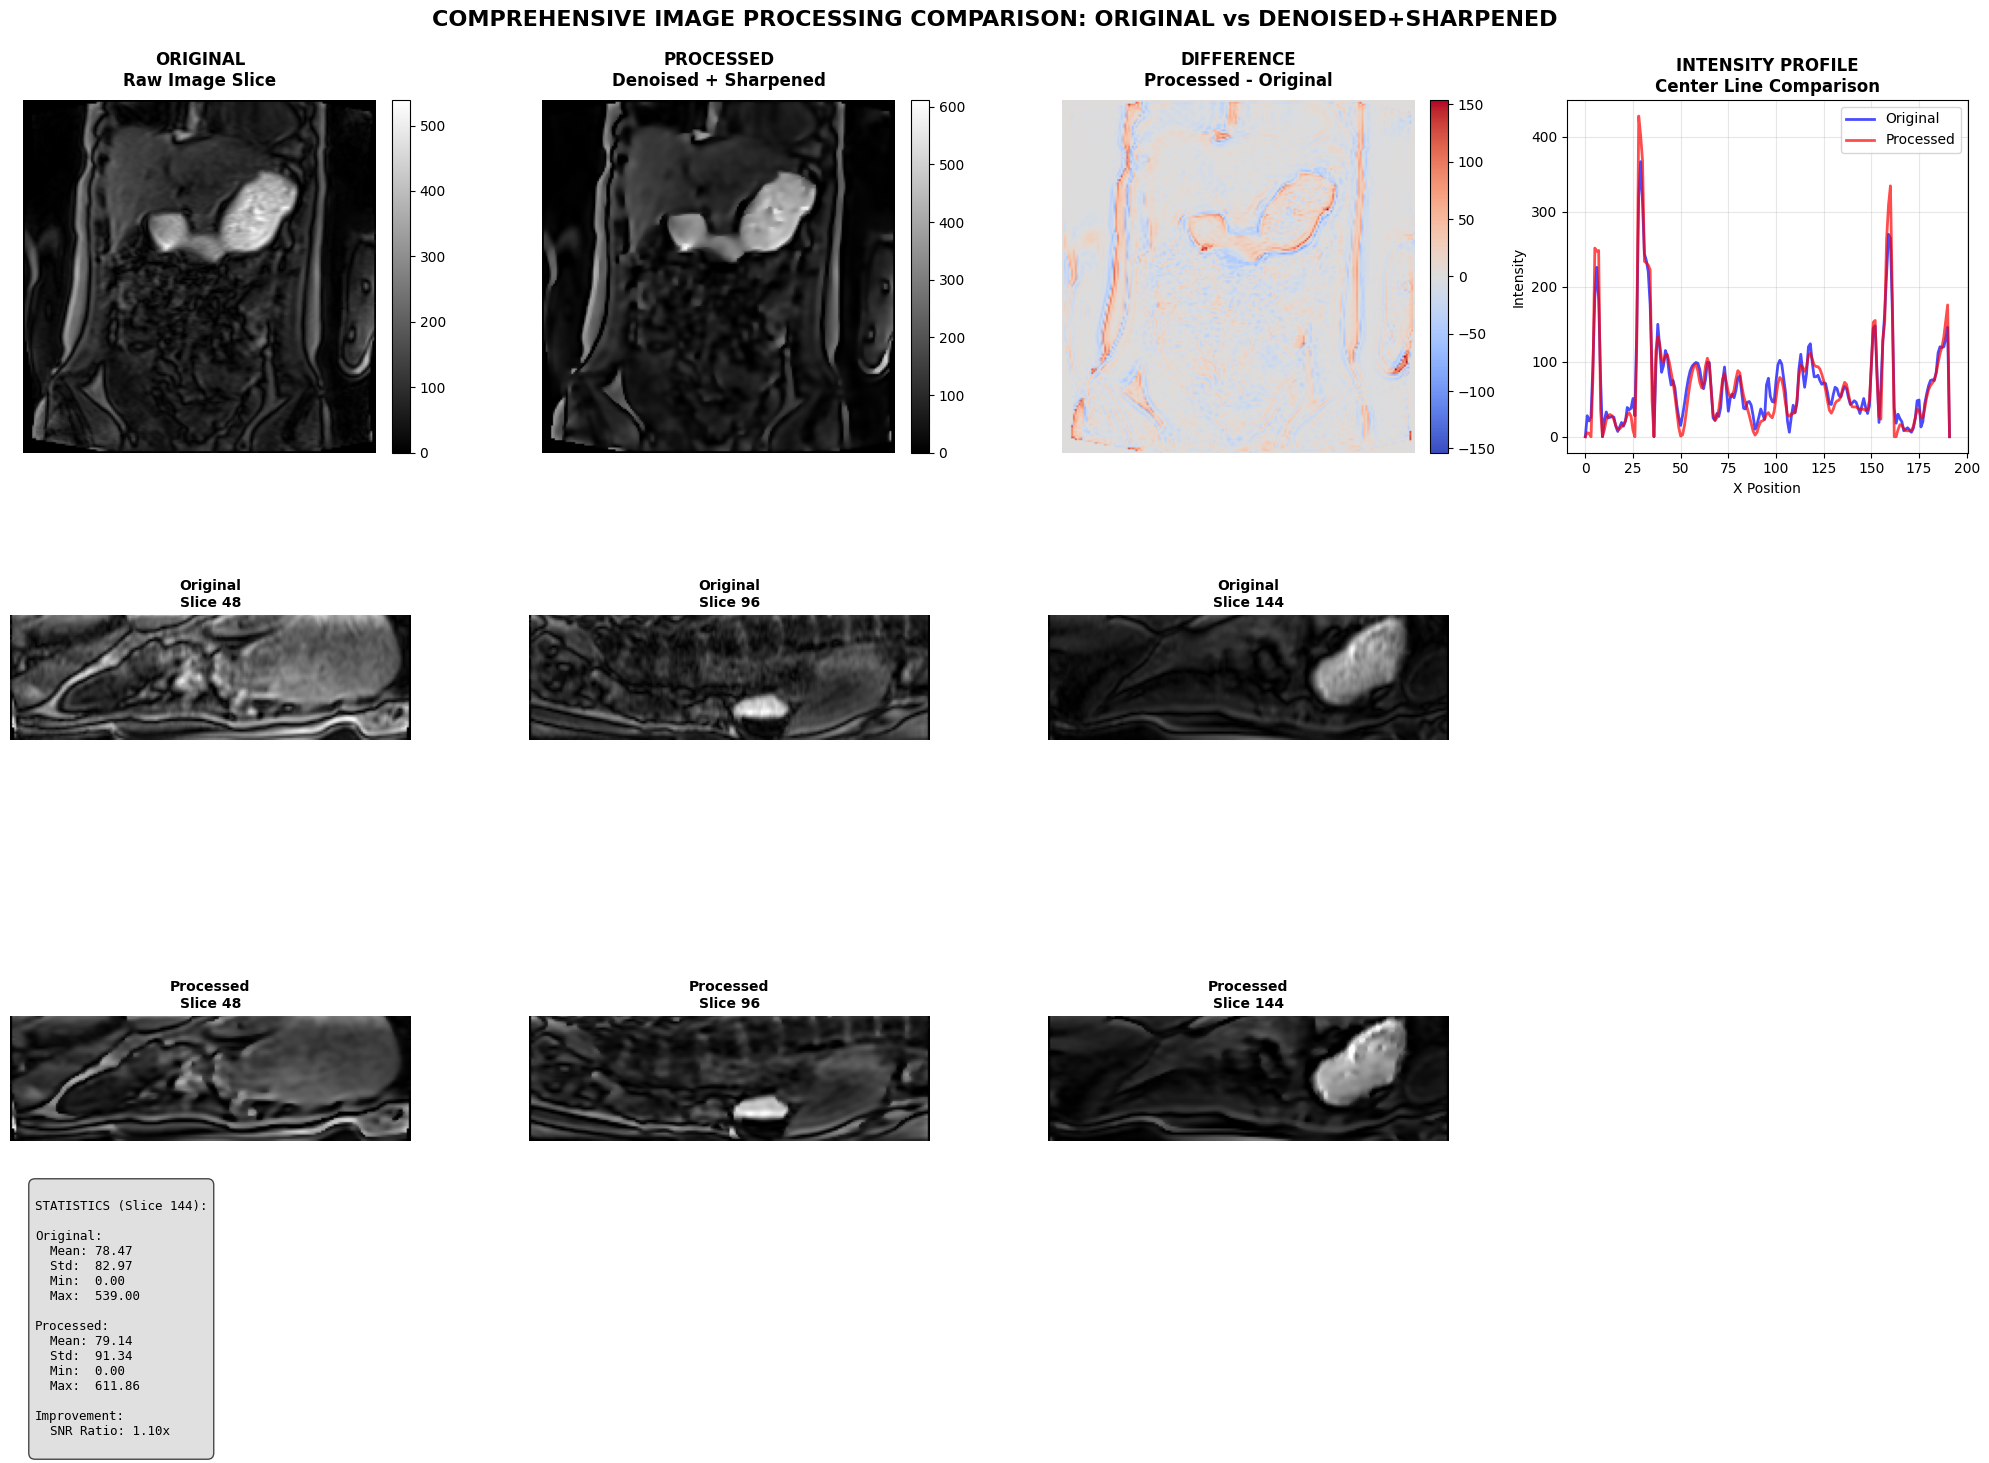


=== CREATING 3D VOLUME VISUALIZATION ===


C:\Users\shanf\AppData\Local\Temp\ipykernel_3376\2356478599.py:242: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


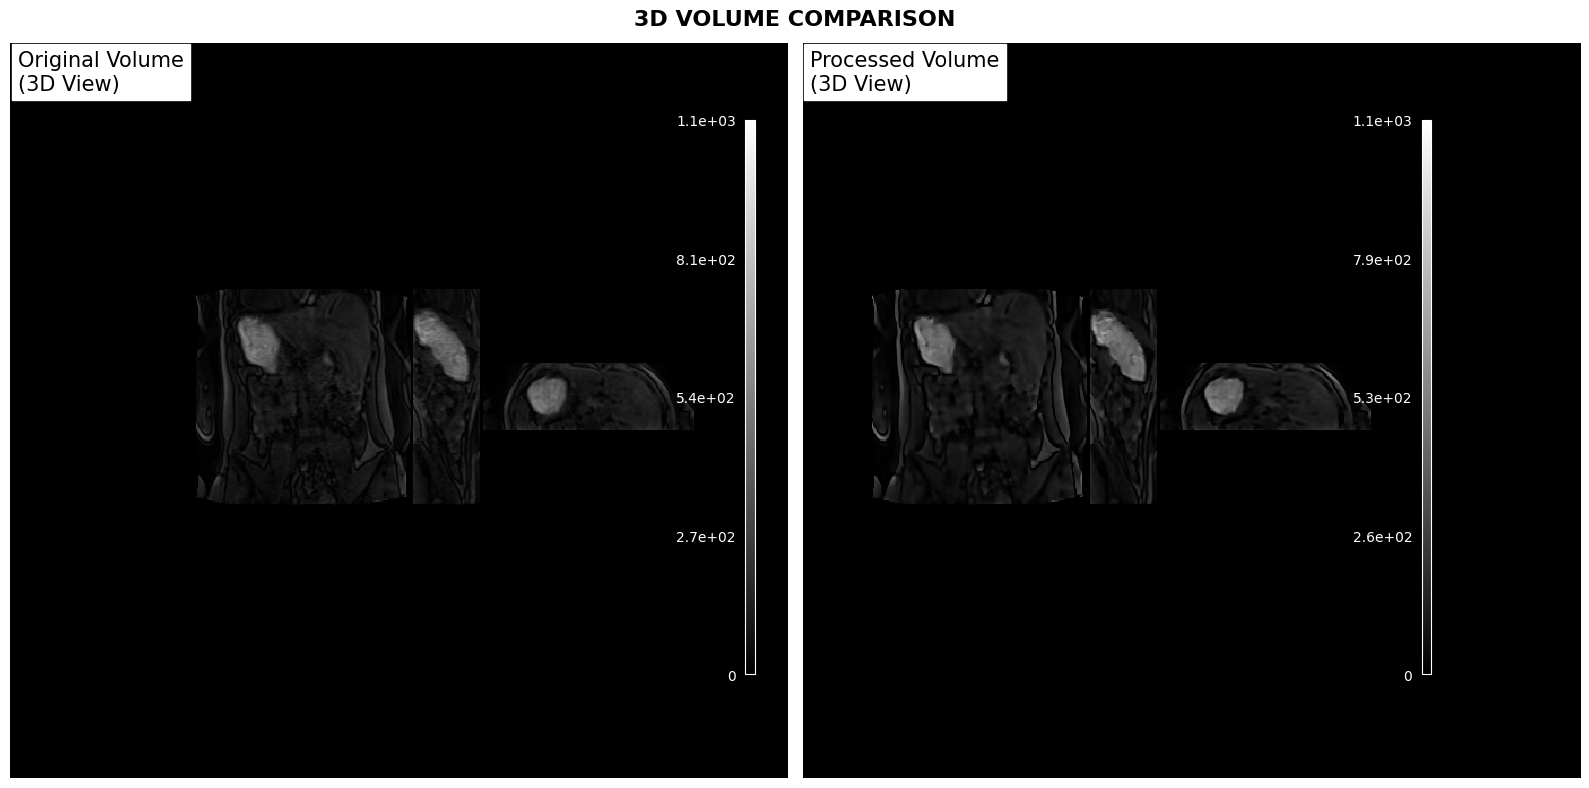


=== CALCULATING QUALITY METRICS ===

=== QUALITY METRICS SUMMARY ===
Signal-to-Noise Ratio (SNR):
  Original:  1.05
  Processed: 0.96
  Improvement: 0.91x

Contrast (Std Dev):
  Original:  76.56
  Processed: 84.72
  Improvement: 1.11x

Reconstruction Quality:
  Mean Squared Error: 315.7771
  PSNR: 32.77 dB



Do you want to save the processed file? (y/n):  n

Do you want to save the visualization? (y/n):  n



=== PROCESSING COMPLETED SUCCESSFULLY ===
✓ Denoising and sharpening applied to all volumes
✓ Comprehensive visualization created
✓ Quality metrics calculated
✓ Processed data stored in variable 'processed_4d_data'
✓ Ready for registration pipeline

Available variables for next steps:
  - processed_4d_data: Denoised and sharpened 4D data (shape: (192, 192, 60, 5))
  - original_4d_data: Original 4D data (shape: (192, 192, 60, 5))
  - original_affine: Affine transformation matrix
  - original_header: NIfTI header information


In [1]:
from nilearn.image import load_img, index_img
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from scipy import ndimage

def anisotropic_diffusion_denoise(image_data, iterations=5, delta_t=0.1, kappa=50):
    """
    Apply Perona-Malik anisotropic diffusion for edge-preserving denoising
    """
    # Initialize with original image
    denoised = image_data.copy().astype(np.float64)
    
    for _ in range(iterations):
        # Calculate gradients in all directions
        grad_north = np.roll(denoised, 1, axis=0) - denoised
        grad_south = np.roll(denoised, -1, axis=0) - denoised
        grad_east = np.roll(denoised, 1, axis=1) - denoised
        grad_west = np.roll(denoised, -1, axis=1) - denoised
        
        # Calculate conduction coefficients (edge-stopping function)
        c_north = np.exp(-(grad_north / kappa) ** 2)
        c_south = np.exp(-(grad_south / kappa) ** 2)
        c_east = np.exp(-(grad_east / kappa) ** 2)
        c_west = np.exp(-(grad_west / kappa) ** 2)
        
        # Update the image
        denoised += delta_t * (
            c_north * grad_north +
            c_south * grad_south +
            c_east * grad_east +
            c_west * grad_west
        )
    
    return denoised

def high_pass_filter_sharpen(image_data, strength=3):
    """
    Apply high-pass filter to sharpen image using unsharp masking approach
    """
    # Create a blurred version (low-pass filter)
    blurred = ndimage.gaussian_filter(image_data, sigma=1.8)
    
    # Subtract blurred from original to get high-pass component (edges/details)
    high_pass = image_data - blurred
    
    # Add the high-pass component back to original to sharpen
    sharpened = image_data + strength * high_pass
    
    # Clip values to maintain valid intensity range
    sharpened = np.clip(sharpened, image_data.min(), image_data.max())
    
    return sharpened

def process_pipeline(image_data, denoise_iterations=10, sharpen_strength=3):
    """
    Complete pipeline: anisotropic diffusion denoising followed by high-pass sharpening
    """
    # Step 1: Denoise with anisotropic diffusion
    denoised = anisotropic_diffusion_denoise(image_data, iterations=denoise_iterations)
    
    # Step 2: Sharpen with high-pass filter
    final = high_pass_filter_sharpen(denoised, strength=sharpen_strength)
    
    return denoised, final

# Load the 4D image file
print("=== LOADING 4D IMAGE FILE ===")
img_4d = load_img('T1w_1.nii')
img_nib = nib.load('T1w_1.nii')

# Store original affine and header for saving later
original_affine = img_nib.affine
original_header = img_nib.header

# Display 4D file information before processing
print("\n=== 4D IMAGE FILE - BEFORE PROCESSING ===")
print(f"File dimensions: {img_4d.shape}")
print(f"Data type: {img_nib.get_data_dtype()}")
print(f"Number of 3D volumes: {img_4d.shape[3]}")
print(f"Voxel sizes (X,Y,Z): {img_nib.header.get_zooms()[:3]}")
total_voxels = np.prod(img_4d.shape)
print(f"Total voxels: {total_voxels:,}")

# Process ALL volumes in the 4D image
print("\n=== PROCESSING ALL VOLUMES IN 4D IMAGE ===")
original_4d_data = img_4d.get_fdata()
processed_4d_data = np.zeros_like(original_4d_data)

# Process each volume individually
for vol_idx in range(original_4d_data.shape[3]):
    print(f"Processing volume {vol_idx + 1}/{original_4d_data.shape[3]}")
    volume_data = original_4d_data[..., vol_idx]
    denoised_data, final_data = process_pipeline(volume_data, denoise_iterations=10, sharpen_strength=0.8)
    processed_4d_data[..., vol_idx] = final_data

print(f"✓ Processed all {original_4d_data.shape[3]} volumes")
print(f"Processed 4D data shape: {processed_4d_data.shape}")

# =============================================================================
# COMPREHENSIVE VISUALIZATION: ORIGINAL vs PROCESSED
# =============================================================================

print("\n=== CREATING COMPREHENSIVE VISUALIZATION ===")

# Use first volume for visualization
first_volume_original = original_4d_data[..., 0]
first_volume_processed = processed_4d_data[..., 0]

# Select multiple slices for comprehensive visualization
slice_indices = [
    first_volume_original.shape[0] // 4,    # Quarter through
    first_volume_original.shape[0] // 2,    # Middle
    first_volume_original.shape[0] * 3 // 4 # Three-quarters through
]

# Create a comprehensive comparison figure
fig = plt.figure(figsize=(20, 15))

# Define color maps for different visualizations
main_cmap = 'gray'
diff_cmap = 'coolwarm'

# Plot 1: Single slice detailed comparison
print("Creating detailed slice comparison...")
slice_idx = first_volume_original.shape[2] // 3
original_slice = first_volume_original[:, :, slice_idx].T
processed_slice = first_volume_processed[:, :, slice_idx].T
difference_slice = processed_slice - original_slice

ax1 = plt.subplot(3, 4, 1)
im1 = ax1.imshow(original_slice, cmap=main_cmap, origin='lower')
ax1.set_title('ORIGINAL\nRaw Image Slice', fontsize=12, fontweight='bold', pad=10)
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

ax2 = plt.subplot(3, 4, 2)
im2 = ax2.imshow(processed_slice, cmap=main_cmap, origin='lower')
ax2.set_title('PROCESSED\nDenoised + Sharpened', fontsize=12, fontweight='bold', pad=10)
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

ax3 = plt.subplot(3, 4, 3)
vmax = np.max(np.abs(difference_slice))
im3 = ax3.imshow(difference_slice, cmap=diff_cmap, origin='lower', 
                vmin=-vmax, vmax=vmax)
ax3.set_title('DIFFERENCE\nProcessed - Original', fontsize=12, fontweight='bold', pad=10)
ax3.axis('off')
plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

# Plot 2: Multiple slices view
print("Creating multi-slice comparison...")
for i, slice_idx in enumerate(slice_indices):
    # Axial slices
    original_axial = first_volume_original[slice_idx, :, :].T
    processed_axial = first_volume_processed[slice_idx, :, :].T
    
    ax_orig = plt.subplot(3, 4, 5 + i)
    ax_orig.imshow(original_axial, cmap=main_cmap, origin='lower')
    ax_orig.set_title(f'Original\nSlice {slice_idx}', fontsize=10, fontweight='bold')
    ax_orig.axis('off')
    
    ax_proc = plt.subplot(3, 4, 9 + i)
    ax_proc.imshow(processed_axial, cmap=main_cmap, origin='lower')
    ax_proc.set_title(f'Processed\nSlice {slice_idx}', fontsize=10, fontweight='bold')
    ax_proc.axis('off')

# Plot 3: Intensity profiles and statistics
print("Creating intensity analysis...")
ax_profile = plt.subplot(3, 4, 4)

# Extract intensity profile through the center
center_y, center_x = original_slice.shape[0] // 2, original_slice.shape[1] // 2
profile_original = original_slice[center_y, :]
profile_processed = processed_slice[center_y, :]

ax_profile.plot(profile_original, 'b-', alpha=0.7, linewidth=2, label='Original')
ax_profile.plot(profile_processed, 'r-', alpha=0.7, linewidth=2, label='Processed')
ax_profile.set_title('INTENSITY PROFILE\nCenter Line Comparison', fontsize=12, fontweight='bold')
ax_profile.legend()
ax_profile.grid(True, alpha=0.3)
ax_profile.set_xlabel('X Position')
ax_profile.set_ylabel('Intensity')

# Add statistics text
stats_text = f"""
STATISTICS (Slice {slice_idx}):

Original:
  Mean: {original_slice.mean():.2f}
  Std:  {original_slice.std():.2f}
  Min:  {original_slice.min():.2f}
  Max:  {original_slice.max():.2f}

Processed:
  Mean: {processed_slice.mean():.2f}
  Std:  {processed_slice.std():.2f}
  Min:  {processed_slice.min():.2f}
  Max:  {processed_slice.max():.2f}

Improvement:
  SNR Ratio: {processed_slice.std()/original_slice.std():.2f}x
"""

fig.text(0.02, 0.02, stats_text, fontfamily='monospace', fontsize=9, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.7))

plt.suptitle('COMPREHENSIVE IMAGE PROCESSING COMPARISON: ORIGINAL vs DENOISED+SHARPENED', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.15)
plt.show()

# =============================================================================
# 3D VOLUME VISUALIZATION (Optional - if you want 3D views)
# =============================================================================

print("\n=== CREATING 3D VOLUME VISUALIZATION ===")

try:
    from nilearn import plotting
    import matplotlib.pyplot as plt
    
    # Create a temporary file for the processed volume for 3D visualization
    temp_processed = nib.Nifti1Image(first_volume_processed, original_affine)
    temp_original = nib.Nifti1Image(first_volume_original, original_affine)
    
    # Create 3D visualization comparison
    fig_3d, axes_3d = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original volume
    plotting.plot_anat(temp_original, axes=axes_3d[0], 
                      title='Original Volume\n(3D View)', 
                      draw_cross=False, annotate=False)
    
    # Processed volume  
    plotting.plot_anat(temp_processed, axes=axes_3d[1],
                      title='Processed Volume\n(3D View)',
                      draw_cross=False, annotate=False)
    
    plt.suptitle('3D VOLUME COMPARISON', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("Note: nilearn plotting not available for 3D visualization")
    print("You can install it with: pip install nilearn")

# =============================================================================
# QUALITY METRICS CALCULATION
# =============================================================================

print("\n=== CALCULATING QUALITY METRICS ===")

def calculate_quality_metrics(original, processed):
    """Calculate various image quality metrics"""
    # Signal-to-Noise Ratio (SNR) approximation
    snr_original = np.mean(original) / np.std(original)
    snr_processed = np.mean(processed) / np.std(processed)
    
    # Contrast (using standard deviation as proxy)
    contrast_original = np.std(original)
    contrast_processed = np.std(processed)
    
    # Mean Squared Error
    mse = np.mean((original - processed) ** 2)
    
    # Peak Signal-to-Noise Ratio (PSNR)
    max_val = np.max(original)
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(max_val / np.sqrt(mse))
    
    return {
        'SNR_original': snr_original,
        'SNR_processed': snr_processed,
        'SNR_improvement': snr_processed / snr_original,
        'Contrast_original': contrast_original,
        'Contrast_processed': contrast_processed,
        'Contrast_improvement': contrast_processed / contrast_original,
        'MSE': mse,
        'PSNR': psnr
    }

# Calculate metrics for the first volume
metrics = calculate_quality_metrics(first_volume_original, first_volume_processed)

print("\n=== QUALITY METRICS SUMMARY ===")
print(f"Signal-to-Noise Ratio (SNR):")
print(f"  Original:  {metrics['SNR_original']:.2f}")
print(f"  Processed: {metrics['SNR_processed']:.2f}")
print(f"  Improvement: {metrics['SNR_improvement']:.2f}x")

print(f"\nContrast (Std Dev):")
print(f"  Original:  {metrics['Contrast_original']:.2f}")
print(f"  Processed: {metrics['Contrast_processed']:.2f}")
print(f"  Improvement: {metrics['Contrast_improvement']:.2f}x")

print(f"\nReconstruction Quality:")
print(f"  Mean Squared Error: {metrics['MSE']:.4f}")
print(f"  PSNR: {metrics['PSNR']:.2f} dB")

# =============================================================================
# SAVE OPTIONS
# =============================================================================

# Option to save processed file
save_processed = input("\nDo you want to save the processed file? (y/n): ").lower().strip()
if save_processed == 'y':
    processed_filename = input("Enter filename for processed data (e.g., 'T1w_1_processed.nii'): ").strip()
    if not processed_filename:
        processed_filename = 'T1w_1_processed.nii'
    
    processed_nifti = nib.Nifti1Image(processed_4d_data, original_affine, header=original_header)
    nib.save(processed_nifti, processed_filename)
    print(f"✓ Processed 4D image saved as '{processed_filename}'")

# Option to save visualization
save_viz = input("\nDo you want to save the visualization? (y/n): ").lower().strip()
if save_viz == 'y':
    viz_filename = input("Enter filename for visualization (e.g., 'processing_comparison.png'): ").strip()
    if not viz_filename:
        viz_filename = 'processing_comparison.png'
    
    plt.figure(fig.number)
    plt.savefig(viz_filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Visualization saved as '{viz_filename}'")

print("\n=== PROCESSING COMPLETED SUCCESSFULLY ===")
print("✓ Denoising and sharpening applied to all volumes")
print("✓ Comprehensive visualization created")
print("✓ Quality metrics calculated")
print("✓ Processed data stored in variable 'processed_4d_data'")
print("✓ Ready for registration pipeline")

print(f"\nAvailable variables for next steps:")
print(f"  - processed_4d_data: Denoised and sharpened 4D data (shape: {processed_4d_data.shape})")
print(f"  - original_4d_data: Original 4D data (shape: {original_4d_data.shape})")
print(f"  - original_affine: Affine transformation matrix")
print(f"  - original_header: NIfTI header information")

# Rigid Registration Pipeline for 4D MRI (Python)

This script performs rigid body image registration for 4D MRI data.
Each 3D volume in the 4D time series is aligned to a fixed reference (the 3D MRI image of the first timestamp) using translation + rotation optimization and normalized cross-correlation (NCC) as the similarity metric.

# Pipeline Overview
## Rigid Transform Construction

The script implements rigid alignment using:

3D Euler rotations (Rx, Ry, Rz)

3D translations (tx, ty, tz)

Rotation matrix creation

Voxel remapping using interpolation

Key functions:
* create_rotation_matrix(angles)

Builds combined rotation matrix from Euler angles.

* apply_rigid_transform(image, translation, rotation_angles)

Applies rotation + translation to a 3D MRI volume using:

Coordinate grid creation

Centering around rotation center

Linear interpolation (ndimage.map_coordinates)

## 2. Similarity Metrics
* Mean Squared Error (MSE)

Basic intensity-difference metric.

* Normalized Cross-Correlation (NCC)

Used for optimization:

Measures similarity independent of intensity scaling.

Script optimizes negative NCC because SciPy minimizes.

## 3. Rigid Registration Optimization
* registration_cost(params, fixed_image, moving_image)

Cost = – NCC(fixed, transformed_moving)
(SciPy minimizes ⇒ maximizing NCC)

* Optimization Details

Optimizer: L-BFGS-B

Parameters (6 total):
[tx, ty, tz, rx, ry, rz]

Bounds:

Translations: ±10 voxels

Rotations: ±0.5 rad (~±30°)

Iterations: 50 max

## 4. Registering Entire 4D Volume
* rigid_register_4d_volume(fixed_volume, moving_volumes)

For each moving 3D volume:

Optimize rigid parameters

Apply rigid transform

Compute similarity before/after

Store aligned volume + parameters

Outputs:

registered_volumes

transformation_params

The first 3D volume is used as the fixed reference.

## Final 4D Registered Output

After registration:

A new 4D dataset is created:

registered_4d_data

=== RIGID REGISTRATION PIPELINE ===
✓ Using processed data from previous cell

=== INPUT DATA FOR REGISTRATION ===
4D image dimensions: (192, 192, 60, 5)
Number of 3D volumes: 5

=== PERFORMING RIGID REGISTRATION ===
Registering volume 1/4...
  Volume 1: Translation [0. 0. 0.], Rotation [0. 0. 0.]
  Similarity (NCC): 0.9289
Registering volume 2/4...
  Volume 2: Translation [0. 0. 0.], Rotation [0. 0. 0.]
  Similarity (NCC): 0.9257
Registering volume 3/4...
  Volume 3: Translation [0. 0. 0.], Rotation [0. 0. 0.]
  Similarity (NCC): 0.9047
Registering volume 4/4...
  Volume 4: Translation [0. 0. 0.], Rotation [0. 0. 0.]
  Similarity (NCC): 0.9016
Registered 4D data shape: (192, 192, 60, 5)

=== VISUALIZING REGISTRATION RESULTS ===


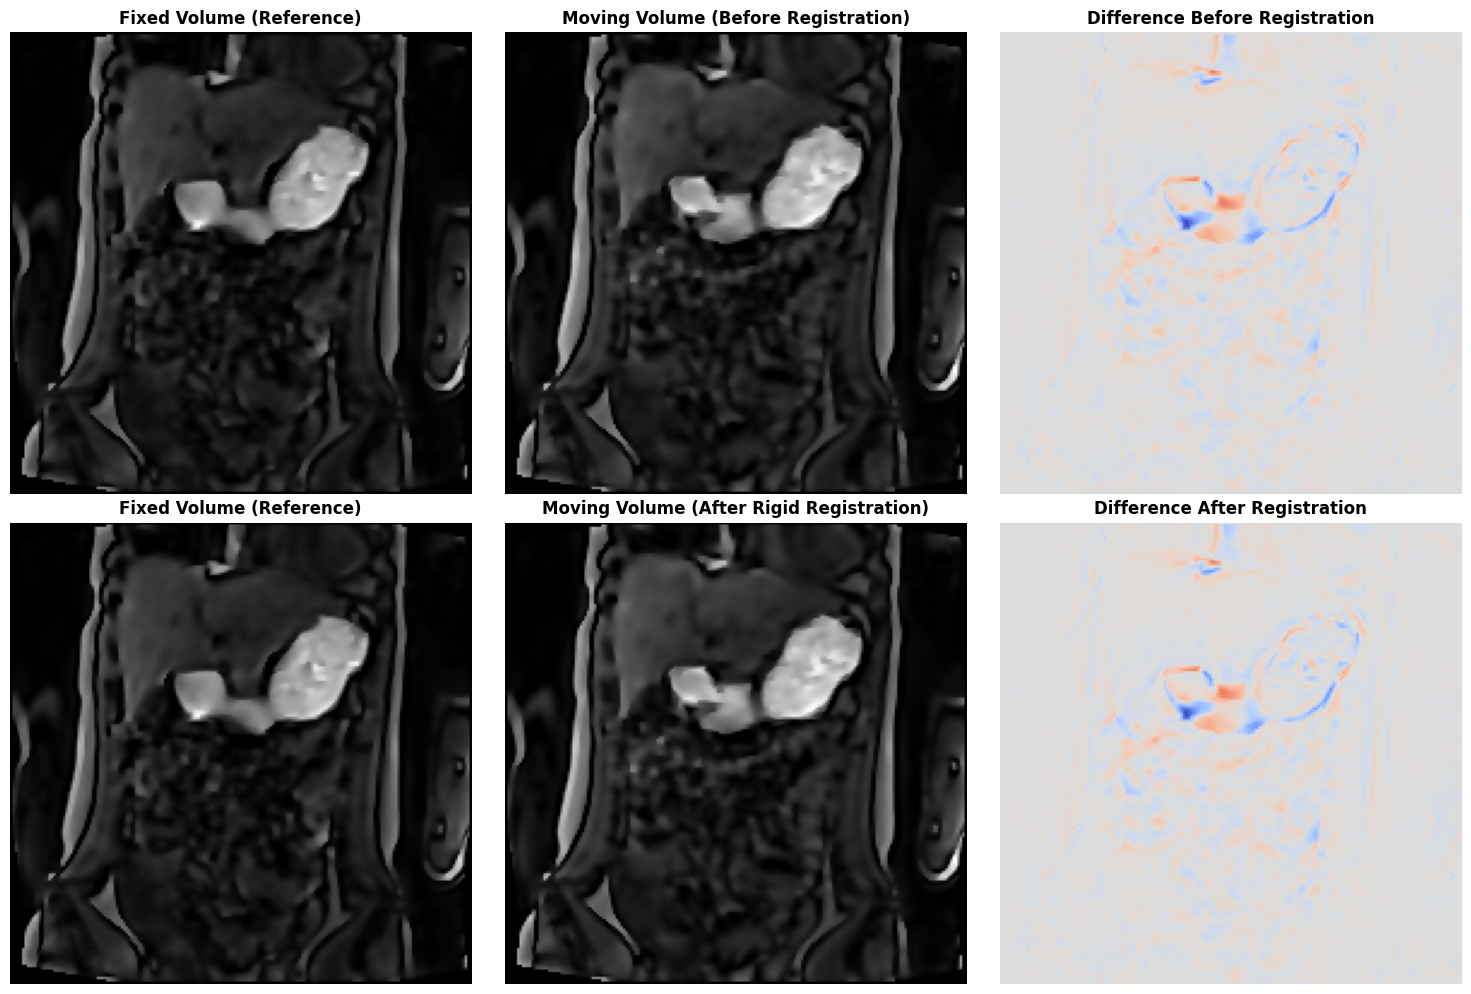


=== REGISTRATION METRICS ===
Volume 2:
  NCC before registration: 0.9289
  NCC after registration:  0.9289
  Improvement: +0.0000
  Transformation: trans=[0. 0. 0.], rot=[0. 0. 0.]
Volume 3:
  NCC before registration: 0.9257
  NCC after registration:  0.9257
  Improvement: +0.0000
  Transformation: trans=[0. 0. 0.], rot=[0. 0. 0.]
Volume 4:
  NCC before registration: 0.9047
  NCC after registration:  0.9047
  Improvement: +0.0000
  Transformation: trans=[0. 0. 0.], rot=[0. 0. 0.]
Volume 5:
  NCC before registration: 0.9016
  NCC after registration:  0.9016
  Improvement: +0.0000
  Transformation: trans=[0. 0. 0.], rot=[0. 0. 0.]



Do you want to save the registered file? (y/n):  n



=== REGISTRATION PIPELINE COMPLETED SUCCESSFULLY ===
✓ Rigid registration applied to align all volumes to reference
✓ Registration metrics calculated and visualized
✓ Registered data stored in variable 'registered_4d_data'


In [2]:
from nilearn.image import concat_imgs
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# RIGID IMAGE REGISTRATION FUNCTIONS
# =============================================================================

def create_rotation_matrix(angles):
    """
    Create 3D rotation matrix from Euler angles (in radians)
    angles = [rx, ry, rz] for rotation around x, y, z axes
    """
    rx, ry, rz = angles
    
    # Rotation around X-axis
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(rx), -np.sin(rx)],
        [0, np.sin(rx), np.cos(rx)]
    ])
    
    # Rotation around Y-axis
    Ry = np.array([
        [np.cos(ry), 0, np.sin(ry)],
        [0, 1, 0],
        [-np.sin(ry), 0, np.cos(ry)]
    ])
    
    # Rotation around Z-axis
    Rz = np.array([
        [np.cos(rz), -np.sin(rz), 0],
        [np.sin(rz), np.cos(rz), 0],
        [0, 0, 1]
    ])
    
    # Combined rotation: Rz * Ry * Rx
    return Rz @ Ry @ Rx

def apply_rigid_transform(image, translation, rotation_angles, center=None):
    """
    Apply rigid transformation to 3D image
    translation = [tx, ty, tz] in voxels
    rotation_angles = [rx, ry, rz] in radians
    """
    if center is None:
        center = np.array(image.shape) / 2
    
    # Create rotation matrix
    R = create_rotation_matrix(rotation_angles)
    t = np.array(translation)
    
    # Create coordinate grid
    z, y, x = np.mgrid[:image.shape[0], :image.shape[1], :image.shape[2]]
    coordinates = np.stack([x.ravel(), y.ravel(), z.ravel()], axis=1)
    
    # Center coordinates
    coordinates_centered = coordinates - center
    
    # Apply rotation
    rotated_coords = coordinates_centered @ R.T
    
    # Apply translation and un-center
    transformed_coords = rotated_coords + center + t
    
    # Reshape back to image dimensions
    transformed_coords = transformed_coords.reshape(image.shape + (3,))
    
    # Apply transformation using interpolation
    transformed_image = ndimage.map_coordinates(
        image, 
        [transformed_coords[..., 2], transformed_coords[..., 1], transformed_coords[..., 0]],
        order=1,  # linear interpolation
        mode='constant',
        cval=0.0
    )
    
    return transformed_image

def mean_squared_error(fixed, moving):
    """Calculate Mean Squared Error between two images"""
    return np.mean((fixed - moving) ** 2)

def normalized_cross_correlation(fixed, moving):
    """Calculate Normalized Cross Correlation between two images"""
    fixed_flat = fixed.flatten()
    moving_flat = moving.flatten()
    
    fixed_normalized = fixed_flat - np.mean(fixed_flat)
    moving_normalized = moving_flat - np.mean(moving_flat)
    
    numerator = np.sum(fixed_normalized * moving_normalized)
    denominator = np.sqrt(np.sum(fixed_normalized ** 2) * np.sum(moving_normalized ** 2))
    
    return numerator / denominator if denominator != 0 else 0

def registration_cost(params, fixed_image, moving_image):
    """
    Cost function for rigid registration optimization
    params = [tx, ty, tz, rx, ry, rz]
    """
    translation = params[:3]
    rotation_angles = params[3:]
    
    # Apply transformation
    transformed_moving = apply_rigid_transform(moving_image, translation, rotation_angles)
    
    # Calculate similarity metric (negative because we minimize)
    # Using negative NCC because we want to maximize NCC but scipy minimizes
    ncc = normalized_cross_correlation(fixed_image, transformed_moving)
    return -ncc  # Negative because we want to maximize NCC

def rigid_register_4d_volume(fixed_volume, moving_volumes, method='NCC'):
    """
    Perform rigid registration of multiple moving volumes to a fixed volume
    
    Parameters:
    - fixed_volume: 3D reference image
    - moving_volumes: list of 3D images to register to fixed volume
    - method: similarity metric ('NCC' or 'MSE')
    
    Returns:
    - registered_volumes: list of registered 3D images
    - transformation_params: list of transformation parameters for each volume
    """
    
    registered_volumes = []
    transformation_params = []
    
    for i, moving_vol in enumerate(moving_volumes):
        print(f"Registering volume {i+1}/{len(moving_volumes)}...")
        
        # Initial guess: no transformation
        initial_params = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        
        # Define bounds for optimization (prevent unrealistic transformations)
        bounds = [
            (-10, 10), (-10, 10), (-10, 10),  # translation bounds (voxels)
            (-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)  # rotation bounds (radians, ~±30 degrees)
        ]
        
        # Perform optimization
        if method == 'NCC':
            result = minimize(
                registration_cost, 
                initial_params, 
                args=(fixed_volume, moving_vol),
                method='L-BFGS-B',
                bounds=bounds,
                options={'maxiter': 50, 'disp': False}
            )
        else:  # MSE
            # For MSE, you'd modify the cost function accordingly
            pass
        
        # Get optimal parameters
        optimal_params = result.x
        transformation_params.append(optimal_params)
        
        # Apply the optimal transformation
        registered_vol = apply_rigid_transform(
            moving_vol, 
            optimal_params[:3], 
            optimal_params[3:]
        )
        
        registered_volumes.append(registered_vol)
        
        print(f"  Volume {i+1}: Translation {optimal_params[:3]}, Rotation {optimal_params[3:]}")
        print(f"  Similarity (NCC): {normalized_cross_correlation(fixed_volume, registered_vol):.4f}")
    
    return registered_volumes, transformation_params

# =============================================================================
# MAIN REGISTRATION PIPELINE
# =============================================================================

print("=== RIGID REGISTRATION PIPELINE ===")

# Check if processed data is available from Code 1
try:
    # Use the processed data from Code 1
    registration_input_data = processed_4d_data
    print("✓ Using processed data from previous cell")
    
except NameError:
    # If not available, ask user to load processed file
    print("Processed data not found in memory. Please load processed file.")
    processed_filename = input("Enter filename of processed data (e.g., 'T1w_1_processed.nii'): ").strip()
    if not processed_filename:
        processed_filename = 'T1w_1_processed.nii'
    
    try:
        processed_img = nib.load(processed_filename)
        registration_input_data = processed_img.get_fdata()
        original_affine = processed_img.affine
        original_header = processed_img.header
        print(f"✓ Loaded processed data from '{processed_filename}'")
    except:
        print("Error: Could not load processed file. Please run Code 1 first.")
        raise

# Display file information
print(f"\n=== INPUT DATA FOR REGISTRATION ===")
print(f"4D image dimensions: {registration_input_data.shape}")
print(f"Number of 3D volumes: {registration_input_data.shape[3]}")

# Perform rigid registration
print("\n=== PERFORMING RIGID REGISTRATION ===")

# Use first volume as fixed reference
fixed_volume = registration_input_data[..., 0]
n_volumes = registration_input_data.shape[3]
moving_volumes = [registration_input_data[..., i] for i in range(1, n_volumes)]

# Perform registration
registered_volumes, transformation_params = rigid_register_4d_volume(
    fixed_volume, moving_volumes, method='NCC'
)

# Create final registered 4D data
registered_4d_data = np.zeros_like(registration_input_data)
registered_4d_data[..., 0] = fixed_volume  # fixed volume remains unchanged
for i, reg_vol in enumerate(registered_volumes):
    registered_4d_data[..., i+1] = reg_vol

print(f"Registered 4D data shape: {registered_4d_data.shape}")

# =============================================================================
# VISUALIZATION OF REGISTRATION RESULTS
# =============================================================================

print("\n=== VISUALIZING REGISTRATION RESULTS ===")

# Select a representative slice and volumes for visualization
slice_idx = fixed_volume.shape[2] // 3
vol1_idx, vol2_idx = 0, min(1, n_volumes-1)  # Compare first two volumes

# Extract slices
original_vol1_slice = registration_input_data[:, :, slice_idx, vol1_idx].T
original_vol2_slice = registration_input_data[:, :, slice_idx, vol2_idx].T
registered_vol2_slice = registered_4d_data[:, :, slice_idx, vol2_idx].T

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Before registration
im1 = axes[0, 0].imshow(original_vol1_slice, cmap='gray', origin='lower')
axes[0, 0].set_title('Fixed Volume (Reference)', fontweight='bold')
axes[0, 0].axis('off')

im2 = axes[0, 1].imshow(original_vol2_slice, cmap='gray', origin='lower')
axes[0, 1].set_title('Moving Volume (Before Registration)', fontweight='bold')
axes[0, 1].axis('off')

difference_before = original_vol2_slice - original_vol1_slice
im3 = axes[0, 2].imshow(difference_before, cmap='coolwarm', origin='lower', 
                       vmin=-np.abs(difference_before).max(), 
                       vmax=np.abs(difference_before).max())
axes[0, 2].set_title('Difference Before Registration', fontweight='bold')
axes[0, 2].axis('off')

# After registration
axes[1, 0].imshow(original_vol1_slice, cmap='gray', origin='lower')
axes[1, 0].set_title('Fixed Volume (Reference)', fontweight='bold')
axes[1, 0].axis('off')

im4 = axes[1, 1].imshow(registered_vol2_slice, cmap='gray', origin='lower')
axes[1, 1].set_title('Moving Volume (After Rigid Registration)', fontweight='bold')
axes[1, 1].axis('off')

difference_after = registered_vol2_slice - original_vol1_slice
im5 = axes[1, 2].imshow(difference_after, cmap='coolwarm', origin='lower',
                       vmin=-np.abs(difference_after).max(),
                       vmax=np.abs(difference_after).max())
axes[1, 2].set_title('Difference After Registration', fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Calculate and display registration metrics
print("\n=== REGISTRATION METRICS ===")
for i in range(len(moving_volumes)):
    original_similarity = normalized_cross_correlation(fixed_volume, moving_volumes[i])
    registered_similarity = normalized_cross_correlation(fixed_volume, registered_volumes[i])
    
    print(f"Volume {i+2}:")
    print(f"  NCC before registration: {original_similarity:.4f}")
    print(f"  NCC after registration:  {registered_similarity:.4f}")
    print(f"  Improvement: {registered_similarity - original_similarity:+.4f}")
    print(f"  Transformation: trans={transformation_params[i][:3]}, rot={transformation_params[i][3:]}")

# Save registered 4D image
save_registered = input("\nDo you want to save the registered file? (y/n): ").lower().strip()
if save_registered == 'y':
    registered_filename = input("Enter filename for registered data (e.g., 'T1w_1_registered.nii'): ").strip()
    if not registered_filename:
        registered_filename = 'T1w_1_registered.nii'
    
    registered_nifti = nib.Nifti1Image(registered_4d_data, original_affine, header=original_header)
    nib.save(registered_nifti, registered_filename)
    print(f"✓ Registered 4D image saved as '{registered_filename}'")

print("\n=== REGISTRATION PIPELINE COMPLETED SUCCESSFULLY ===")
print("✓ Rigid registration applied to align all volumes to reference")
print("✓ Registration metrics calculated and visualized")
print("✓ Registered data stored in variable 'registered_4d_data'")

# Binary Otsu Thresholding

We use Otsu’s method to convert the MRI volume into a binary mask that separates stomach tissue from the background.
Otsu’s algorithm automatically finds an optimal threshold by maximizing the variance between the two intensity classes, giving a clean initial segmentation without manual tuning.

* Class 0 → background

* Class 1 → foreground (stomach / high-intensity region)

Because raw Otsu on MRI can be too permissive, the script applies a scaling factor:

final_threshold = otsu_threshold × THRESHOLD_ADJUST


Default:

THRESHOLD_ADJUST = 30


Higher values → More conservative segmentation (fewer voxels).
Users can modify this interactively.

# Segmentation Pipeline

For each 3D volume in the 4D dataset:

Compute Otsu threshold

Apply user scaling

Create binary mask

Clean mask with:

3×3×3 binary closing

3×3×3 binary opening

Store mask in:

segmented_4d[..., t]



=== OTSU THRESHOLDING PIPELINE ===
✓ Using registered data from previous cell

=== INPUT DATA FOR SEGMENTATION ===
4D image dimensions: (192, 192, 60, 5)
Number of 3D volumes: 5



Enter threshold adjustment factor (default 30, higher=more conservative):  40


Threshold adjustment: 40.0

=== SEGMENTING 5 VOLUMES ===
Volume 1: 51,665 voxels (threshold: 293.013)
Volume 2: 58,703 voxels (threshold: 253.785)
Volume 3: 8,716 voxels (threshold: 480.753)
Volume 4: 49,760 voxels (threshold: 297.273)
Volume 5: 51,587 voxels (threshold: 280.960)

=== CREATING COMPREHENSIVE VISUALIZATION ===
First volume threshold: 293.013
Segmented voxels in first volume: 51,665
Creating before/after comparison...
Creating overlay visualization...
Creating intensity analysis...


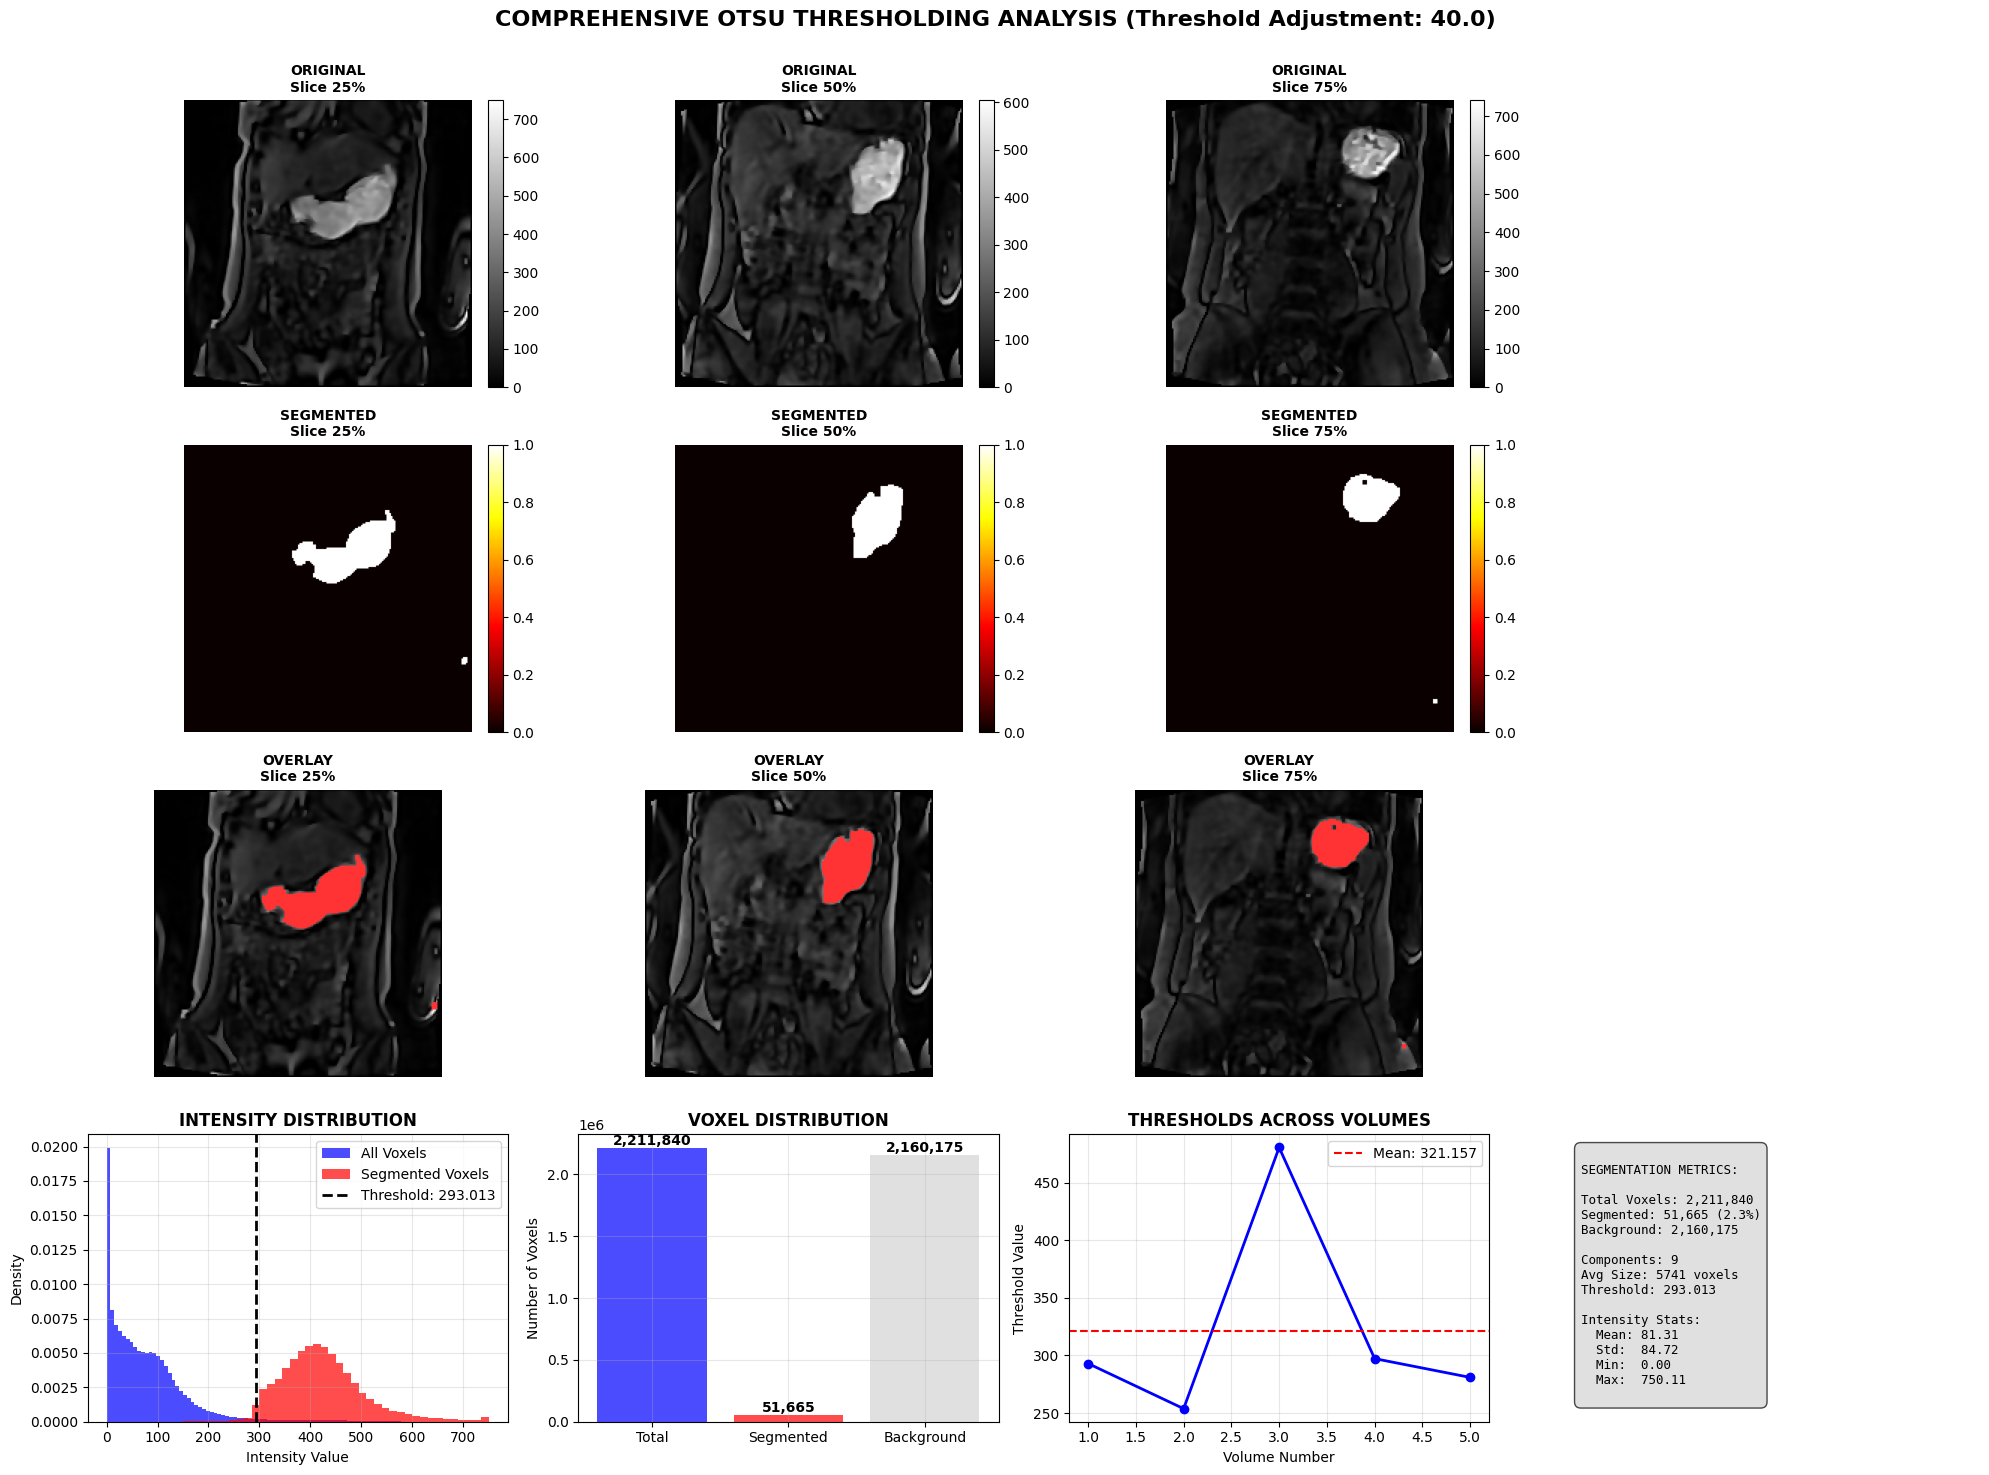


Do you want to save the segmented file? (y/n):  n

Do you want to save the visualization? (y/n):  n



=== OTSU THRESHOLDING COMPLETED SUCCESSFULLY ===
✓ All volumes segmented using Otsu thresholding
✓ Comprehensive visualization created
✓ Segmentation metrics calculated
✓ Segmented data stored in variable 'segmented_4d'

Available variables for next steps:
  - segmented_4d: Binary segmented 4D data (shape: (192, 192, 60, 5))
  - input_data: Original registered data (shape: (192, 192, 60, 5))
  - volume_thresholds: List of thresholds used for each volume
  - first_volume_segmented: First volume segmentation mask

=== SEGMENTATION SUMMARY ===
Total volumes processed: 5
Average threshold value: 321.157 ± 81.226
First volume segmentation: 51,665 voxels (2.3% of volume)


In [3]:
def simple_otsu_threshold(image):
    """
    Simple Otsu thresholding implementation
    """
    flat_image = image.flatten()
    flat_image = flat_image[np.isfinite(flat_image)]
    hist, bin_edges = np.histogram(flat_image, bins=256, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    mean1 = np.cumsum(hist * bin_centers) / np.maximum(weight1, 1e-10)
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / np.maximum(weight2, 1e-10))[::-1]
    variance_between = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    return bin_centers[:-1][np.argmax(variance_between)] if len(variance_between) > 0 else np.mean(flat_image)

# =============================================================================
# MAIN OTSU THRESHOLDING PIPELINE
# =============================================================================

print("=== OTSU THRESHOLDING PIPELINE ===")

# Check if registered data is available from Code 2
try:
    # Use the registered data from Code 2
    input_data = registered_4d_data
    input_affine = original_affine
    print("✓ Using registered data from previous cell")
    
except NameError:
    # If not available, ask user to load registered file
    print("Registered data not found in memory. Please load registered file.")
    registered_filename = input("Enter filename of registered data (e.g., 'T1w_1_registered.nii'): ").strip()
    if not registered_filename:
        registered_filename = 'T1w_1_registered.nii'
    
    try:
        registered_img = nib.load(registered_filename)
        input_data = registered_img.get_fdata()
        input_affine = registered_img.affine
        print(f"✓ Loaded registered data from '{registered_filename}'")
    except:
        print("Error: Could not load registered file. Please run Code 2 first.")
        raise

print(f"\n=== INPUT DATA FOR SEGMENTATION ===")
print(f"4D image dimensions: {input_data.shape}")
print(f"Number of 3D volumes: {input_data.shape[3]}")

# ADJUSTABLE PARAMETERS
THRESHOLD_ADJUST = float(input(f"\nEnter threshold adjustment factor (default 30, higher=more conservative): ") or "30")
print(f"Threshold adjustment: {THRESHOLD_ADJUST}")

# Initialize segmented data
segmented_4d = np.zeros_like(input_data, dtype=np.uint8)

print(f"\n=== SEGMENTING {input_data.shape[3]} VOLUMES ===")

# Store first volume for visualization
first_volume_original = input_data[..., 0].copy()
first_volume_segmented = None
volume_thresholds = []

for vol_idx in range(input_data.shape[3]):
    volume_data = input_data[..., vol_idx]
    otsu_thresh = simple_otsu_threshold(volume_data)
    final_thresh = otsu_thresh * THRESHOLD_ADJUST
    binary_mask = (volume_data > final_thresh).astype(np.uint8)
    
    # Clean up the mask
    structure = np.ones((3, 3, 3), dtype=bool)
    binary_mask = ndimage.binary_closing(binary_mask, structure=structure)
    binary_mask = ndimage.binary_opening(binary_mask, structure=structure)
    
    segmented_4d[..., vol_idx] = binary_mask
    volume_thresholds.append(final_thresh)
    
    # Store first volume segmentation for visualization
    if vol_idx == 0:
        first_volume_segmented = binary_mask.copy()
        first_volume_threshold = final_thresh
    
    print(f"Volume {vol_idx+1}: {np.sum(binary_mask):,} voxels (threshold: {final_thresh:.3f})")

# =============================================================================
# COMPREHENSIVE VISUALIZATION
# =============================================================================

print(f"\n=== CREATING COMPREHENSIVE VISUALIZATION ===")
print(f"First volume threshold: {first_volume_threshold:.3f}")
print(f"Segmented voxels in first volume: {np.sum(first_volume_segmented):,}")

# Create comprehensive visualization figure
fig = plt.figure(figsize=(20, 15))

# Select multiple slices for comprehensive visualization
slice_indices = [
    first_volume_original.shape[2] // 4,    # 25% slice
    first_volume_original.shape[2] // 2,    # 50% slice (middle)
    first_volume_original.shape[2] * 3 // 4 # 75% slice
]

slice_names = ['Slice 25%', 'Slice 50%', 'Slice 75%']

# Plot 1: Before/After comparison
print("Creating before/after comparison...")
for i, slice_idx in enumerate(slice_indices):
    # Original image
    original_slice = first_volume_original[:, :, slice_idx].T
    ax_orig = plt.subplot(4, 4, i + 1)
    im_orig = ax_orig.imshow(original_slice, cmap='gray', origin='lower')
    ax_orig.set_title(f'ORIGINAL\n{slice_names[i]}', fontsize=10, fontweight='bold')
    ax_orig.axis('off')
    plt.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.04)
    
    # Segmented image
    segmented_slice = first_volume_segmented[:, :, slice_idx].T
    ax_seg = plt.subplot(4, 4, i + 5)
    im_seg = ax_seg.imshow(segmented_slice, cmap='hot', origin='lower')
    ax_seg.set_title(f'SEGMENTED\n{slice_names[i]}', fontsize=10, fontweight='bold')
    ax_seg.axis('off')
    plt.colorbar(im_seg, ax=ax_seg, fraction=0.046, pad=0.04)

# Plot 2: Overlay visualization
print("Creating overlay visualization...")
for i, slice_idx in enumerate(slice_indices):
    original_slice = first_volume_original[:, :, slice_idx].T
    segmented_slice = first_volume_segmented[:, :, slice_idx].T
    
    # Create RGB overlay
    overlay = np.stack([original_slice] * 3, axis=-1)
    
    # Normalize to [0,1] range
    overlay = (overlay - overlay.min()) / (overlay.max() - overlay.min())
    
    # Apply red color to segmented regions
    red_mask = segmented_slice > 0
    overlay[red_mask, 0] = 1.0   # Red channel
    overlay[red_mask, 1] = 0.2   # Green channel (reduced)
    overlay[red_mask, 2] = 0.2   # Blue channel (reduced)
    
    ax_overlay = plt.subplot(4, 4, i + 9)
    ax_overlay.imshow(overlay, origin='lower')
    ax_overlay.set_title(f'OVERLAY\n{slice_names[i]}', fontsize=10, fontweight='bold')
    ax_overlay.axis('off')

# Plot 3: Intensity histogram with threshold
print("Creating intensity analysis...")
ax_hist = plt.subplot(4, 4, 13)

# Plot histogram of all voxels
all_intensities = first_volume_original.flatten()
n, bins, patches = ax_hist.hist(all_intensities, bins=100, alpha=0.7, color='blue', 
                               label='All Voxels', density=True)

# Plot histogram of segmented voxels
if np.any(first_volume_segmented):
    segmented_intensities = first_volume_original[first_volume_segmented > 0]
    ax_hist.hist(segmented_intensities, bins=50, alpha=0.7, color='red', 
                label='Segmented Voxels', density=True)

# Mark the threshold
ax_hist.axvline(first_volume_threshold, color='black', linestyle='--', linewidth=2, 
               label=f'Threshold: {first_volume_threshold:.3f}')

ax_hist.set_xlabel('Intensity Value')
ax_hist.set_ylabel('Density')
ax_hist.set_title('INTENSITY DISTRIBUTION', fontweight='bold')
ax_hist.legend()
ax_hist.grid(True, alpha=0.3)

# Plot 4: Volume statistics and segmentation metrics
ax_stats = plt.subplot(4, 4, 14)

# Calculate statistics
total_voxels = first_volume_original.size
segmented_voxels = np.sum(first_volume_segmented)
segmentation_percentage = (segmented_voxels / total_voxels) * 100

# Create bar chart for volume statistics
categories = ['Total', 'Segmented', 'Background']
values = [total_voxels, segmented_voxels, total_voxels - segmented_voxels]
colors = ['blue', 'red', 'lightgray']

bars = ax_stats.bar(categories, values, color=colors, alpha=0.7)
ax_stats.set_ylabel('Number of Voxels')
ax_stats.set_title('VOXEL DISTRIBUTION', fontweight='bold')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax_stats.text(bar.get_x() + bar.get_width()/2., height,
                 f'{value:,}', ha='center', va='bottom', fontweight='bold')

ax_stats.grid(True, alpha=0.3)

# Plot 5: Threshold distribution across volumes
ax_thresh = plt.subplot(4, 4, 15)

if len(volume_thresholds) > 1:
    volumes = range(1, len(volume_thresholds) + 1)
    ax_thresh.plot(volumes, volume_thresholds, 'bo-', linewidth=2, markersize=6)
    ax_thresh.set_xlabel('Volume Number')
    ax_thresh.set_ylabel('Threshold Value')
    ax_thresh.set_title('THRESHOLDS ACROSS VOLUMES', fontweight='bold')
    ax_thresh.grid(True, alpha=0.3)
    
    # Add statistics
    mean_thresh = np.mean(volume_thresholds)
    std_thresh = np.std(volume_thresholds)
    ax_thresh.axhline(mean_thresh, color='red', linestyle='--', 
                     label=f'Mean: {mean_thresh:.3f}')
    ax_thresh.legend()
else:
    ax_thresh.text(0.5, 0.5, 'Single Volume\nNo Volume Comparison', 
                  ha='center', va='center', transform=ax_thresh.transAxes,
                  fontweight='bold', fontsize=12)
    ax_thresh.axis('off')

# Plot 6: Segmentation quality metrics
ax_metrics = plt.subplot(4, 4, 16)

# Calculate additional metrics
if np.any(first_volume_segmented):
    # Connected components analysis
    labeled_array, num_features = ndimage.label(first_volume_segmented)
    
    # Component sizes
    component_sizes = [np.sum(labeled_array == i) for i in range(1, num_features + 1)]
    avg_component_size = np.mean(component_sizes) if component_sizes else 0
    
    metrics_text = f"""
SEGMENTATION METRICS:

Total Voxels: {total_voxels:,}
Segmented: {segmented_voxels:,} ({segmentation_percentage:.1f}%)
Background: {total_voxels - segmented_voxels:,}

Components: {num_features}
Avg Size: {avg_component_size:.0f} voxels
Threshold: {first_volume_threshold:.3f}

Intensity Stats:
  Mean: {np.mean(first_volume_original):.2f}
  Std:  {np.std(first_volume_original):.2f}
  Min:  {np.min(first_volume_original):.2f}
  Max:  {np.max(first_volume_original):.2f}
"""
else:
    metrics_text = "No segmentation found!\nTry lowering the threshold."

ax_metrics.text(0.05, 0.95, metrics_text, transform=ax_metrics.transAxes,
               fontfamily='monospace', fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.7))
ax_metrics.axis('off')

plt.suptitle(f'COMPREHENSIVE OTSU THRESHOLDING ANALYSIS (Threshold Adjustment: {THRESHOLD_ADJUST})', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# =============================================================================
# SAVE OPTIONS
# =============================================================================

# Option to save segmented file
save_segmented = input("\nDo you want to save the segmented file? (y/n): ").lower().strip()
if save_segmented == 'y':
    segmented_filename = input("Enter filename for segmented data (e.g., 'T1w_1_segmented.nii'): ").strip()
    if not segmented_filename:
        segmented_filename = 'T1w_1_segmented.nii'
    
    segmented_nifti = nib.Nifti1Image(segmented_4d.astype(np.uint8), input_affine)
    nib.save(segmented_nifti, segmented_filename)
    print(f"✓ Segmented 4D image saved as '{segmented_filename}'")

# Option to save visualization
save_viz = input("\nDo you want to save the visualization? (y/n): ").lower().strip()
if save_viz == 'y':
    viz_filename = input("Enter filename for visualization (e.g., 'otsu_segmentation.png'): ").strip()
    if not viz_filename:
        viz_filename = 'otsu_segmentation.png'
    
    plt.figure(fig.number)
    plt.savefig(viz_filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Visualization saved as '{viz_filename}'")

print("\n=== OTSU THRESHOLDING COMPLETED SUCCESSFULLY ===")
print("✓ All volumes segmented using Otsu thresholding")
print("✓ Comprehensive visualization created")
print("✓ Segmentation metrics calculated")
print("✓ Segmented data stored in variable 'segmented_4d'")

print(f"\nAvailable variables for next steps:")
print(f"  - segmented_4d: Binary segmented 4D data (shape: {segmented_4d.shape})")
print(f"  - input_data: Original registered data (shape: {input_data.shape})")
print(f"  - volume_thresholds: List of thresholds used for each volume")
print(f"  - first_volume_segmented: First volume segmentation mask")

# Print final summary
print(f"\n=== SEGMENTATION SUMMARY ===")
print(f"Total volumes processed: {input_data.shape[3]}")
print(f"Average threshold value: {np.mean(volume_thresholds):.3f} ± {np.std(volume_thresholds):.3f}")
print(f"First volume segmentation: {np.sum(first_volume_segmented):,} voxels ({segmentation_percentage:.1f}% of volume)")

# Post-Processing: Largest Component Extraction

Purpose:
After Otsu thresholding, segmentation may contain multiple disconnected regions (components). This step keeps only the largest connected component per volume to remove small artifacts and noise.

Steps:

## Input:

segmented_4d from Otsu thresholding (binary mask, 4D: X×Y×Z×T).

Process each 3D volume independently:

Connected component labeling → identify all separate components.

Keep largest component → remove smaller components.

Compute statistics: number of components, voxel counts, size of largest component, percent reduction.

## Output:

cleaned_mask_4d → binary mask containing only the largest component per volume.

Optional: Save the cleaned mask as a NIfTI file for further analysis.

=== POST-PROCESSING PIPELINE - LARGEST COMPONENT EXTRACTION ===
✓ Using segmented data from previous cell

=== INPUT DATA FOR POST-PROCESSING ===
4D mask dimensions: (192, 192, 60, 5)
Number of 3D volumes: 5

=== PROCESSING 5 VOLUMES ===
Cleaning volume 1/5...
  Original: 9 components, 51665 voxels
  Cleaned:  1 component, 50229.0 voxels
  Reduction: 2.8%
Cleaning volume 2/5...
  Original: 28 components, 58703 voxels
  Cleaned:  1 component, 52439.0 voxels
  Reduction: 10.7%
Cleaning volume 3/5...
  Original: 2 components, 8716 voxels
  Cleaned:  1 component, 8689.0 voxels
  Reduction: 0.3%
Cleaning volume 4/5...
  Original: 6 components, 49760 voxels
  Cleaned:  1 component, 48640.0 voxels
  Reduction: 2.3%
Cleaning volume 5/5...
  Original: 10 components, 51587 voxels
  Cleaned:  1 component, 49889.0 voxels
  Reduction: 3.3%

=== DISPLAYING ALL 5 VOLUMES ===

--- Displaying Volume 0 ---


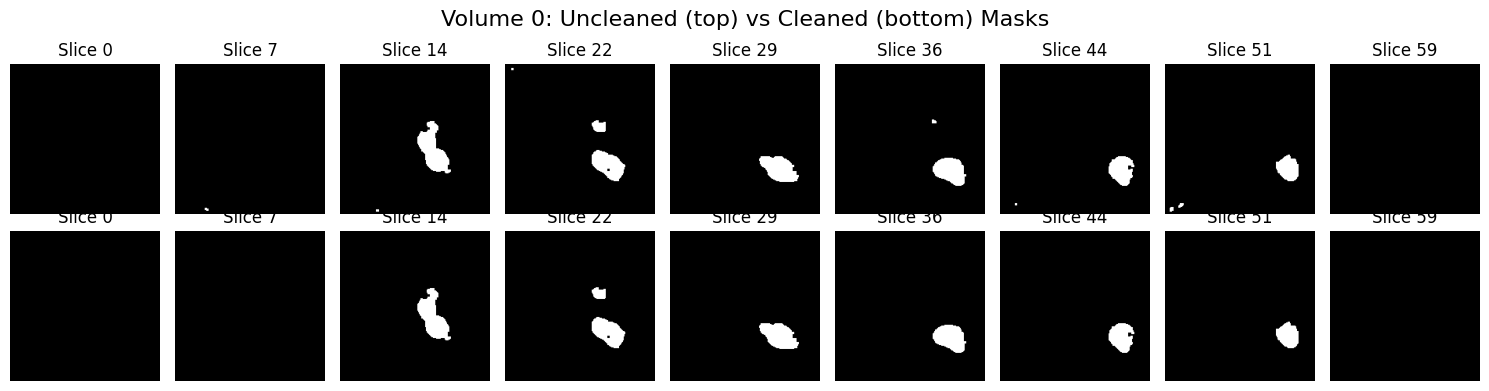


--- Displaying Volume 1 ---


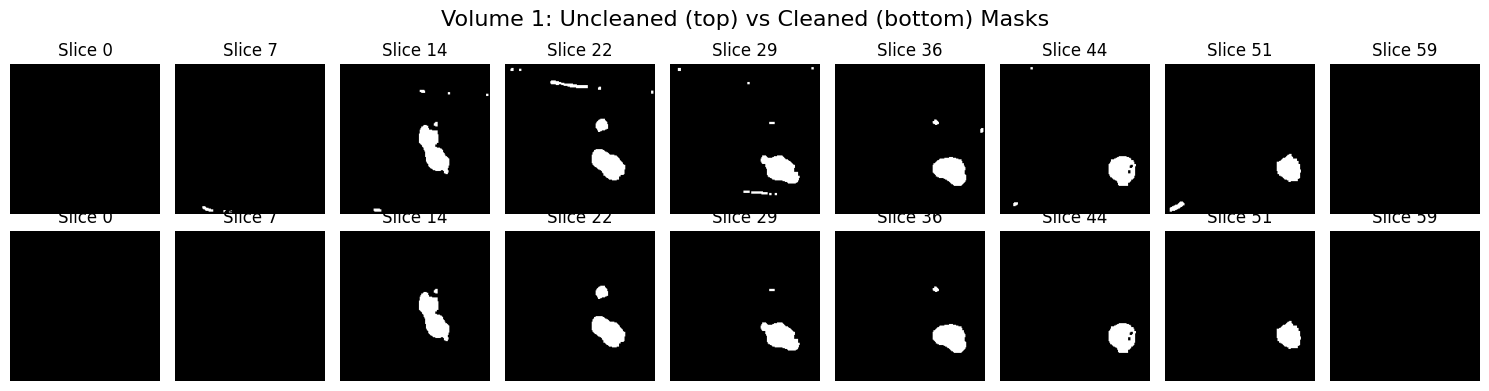


--- Displaying Volume 2 ---


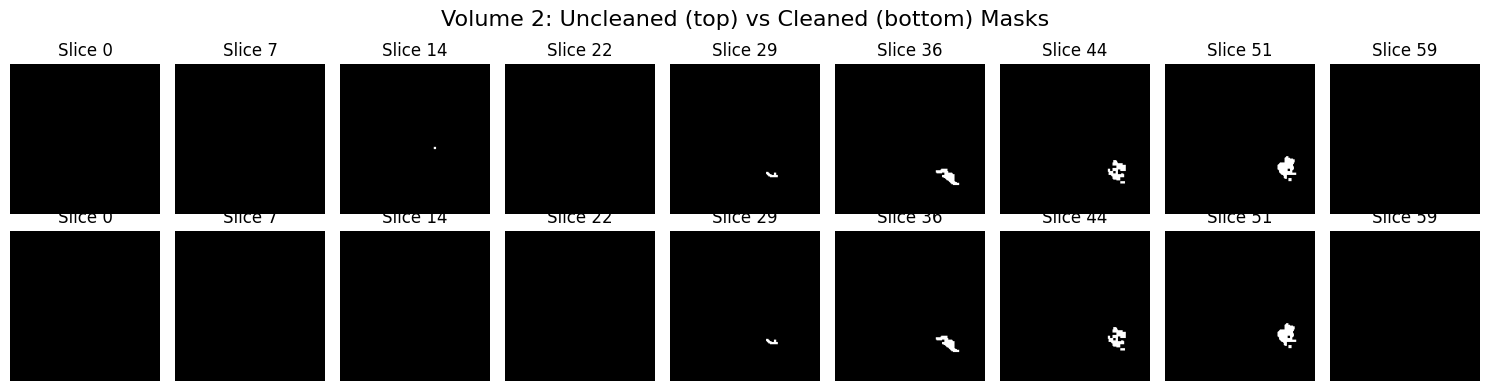


--- Displaying Volume 3 ---


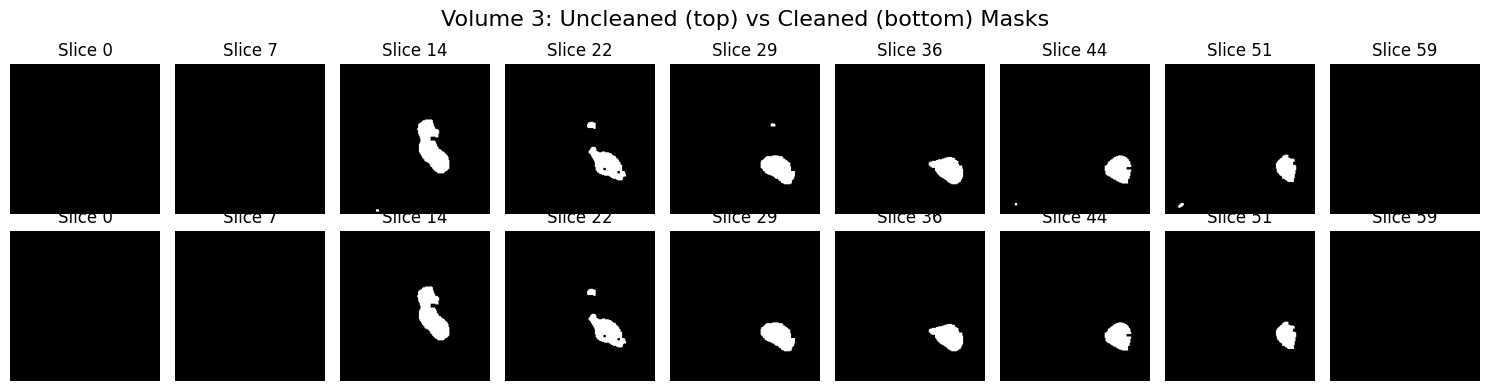


--- Displaying Volume 4 ---


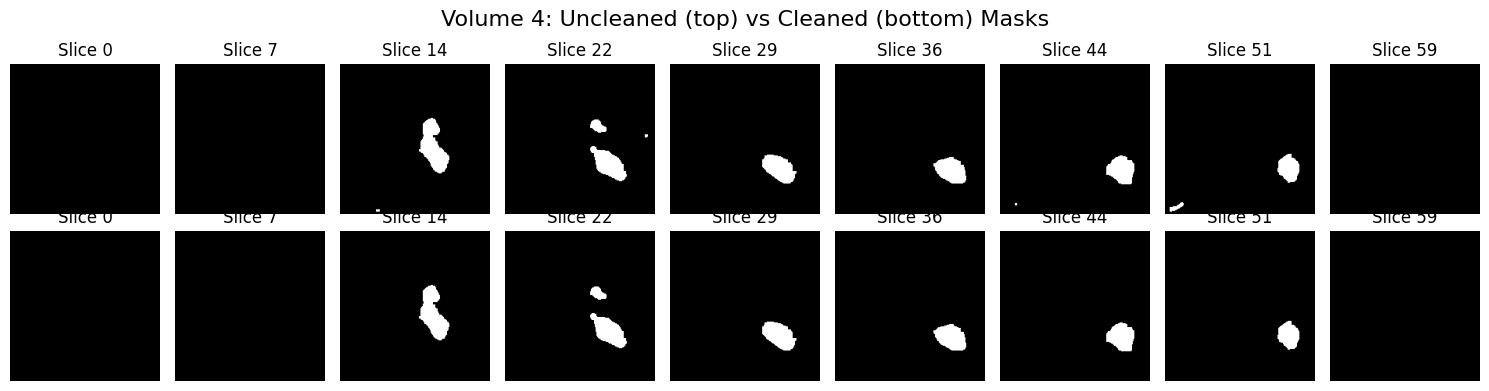


--- Component Analysis for Volume 0 ---

--- Volume 0 Comparison ---
Uncleaned: 9 components, 51665 voxels
Cleaned:   1 components, 50229 voxels
Removed:   1436 voxels
Reduction: 2.8%


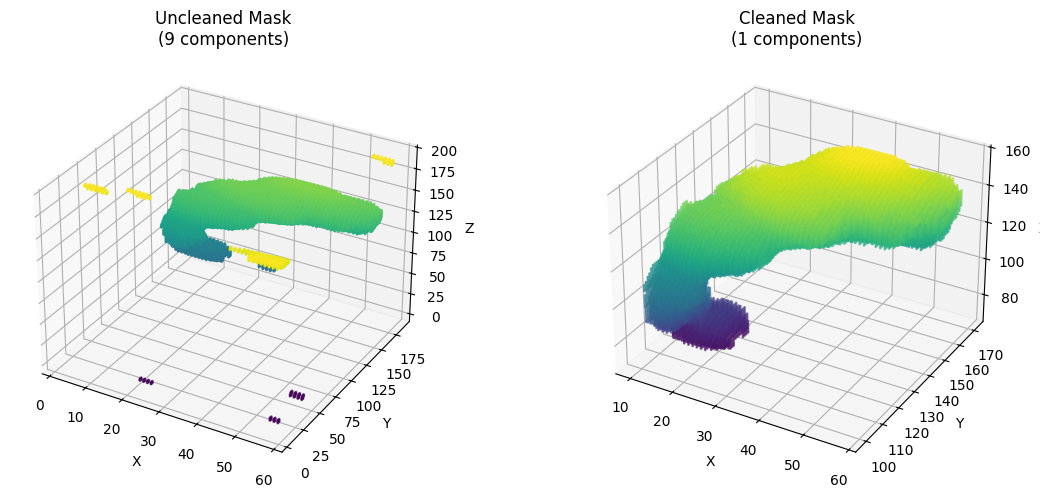


--- Component Analysis for Volume 1 ---

--- Volume 1 Comparison ---
Uncleaned: 28 components, 58703 voxels
Cleaned:   1 components, 52439 voxels
Removed:   6264 voxels
Reduction: 10.7%


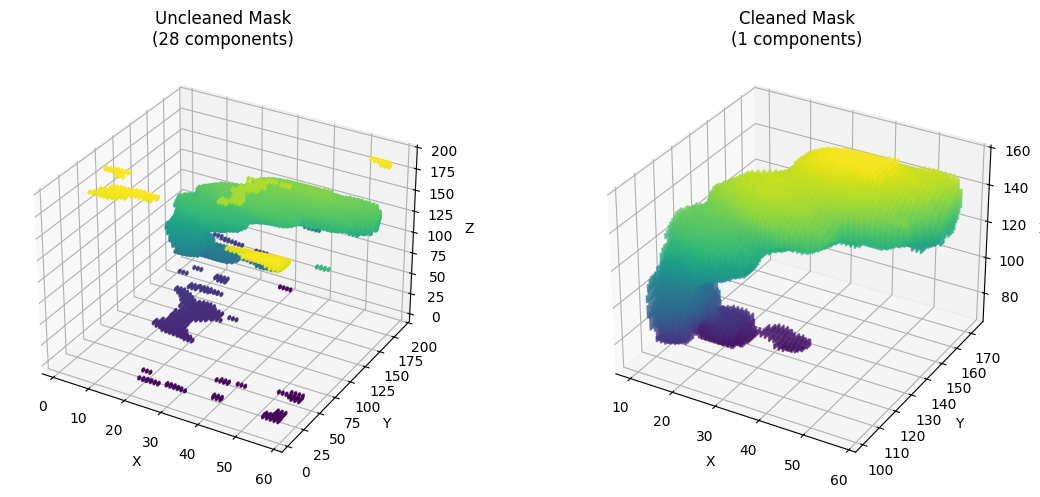


--- Component Analysis for Volume 2 ---

--- Volume 2 Comparison ---
Uncleaned: 2 components, 8716 voxels
Cleaned:   1 components, 8689 voxels
Removed:   27 voxels
Reduction: 0.3%


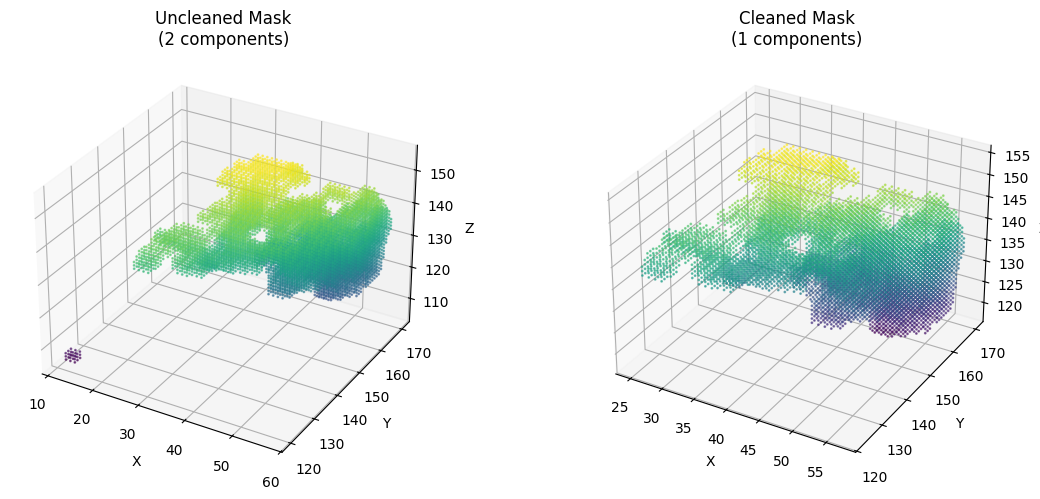


--- Component Analysis for Volume 3 ---

--- Volume 3 Comparison ---
Uncleaned: 6 components, 49760 voxels
Cleaned:   1 components, 48640 voxels
Removed:   1120 voxels
Reduction: 2.3%


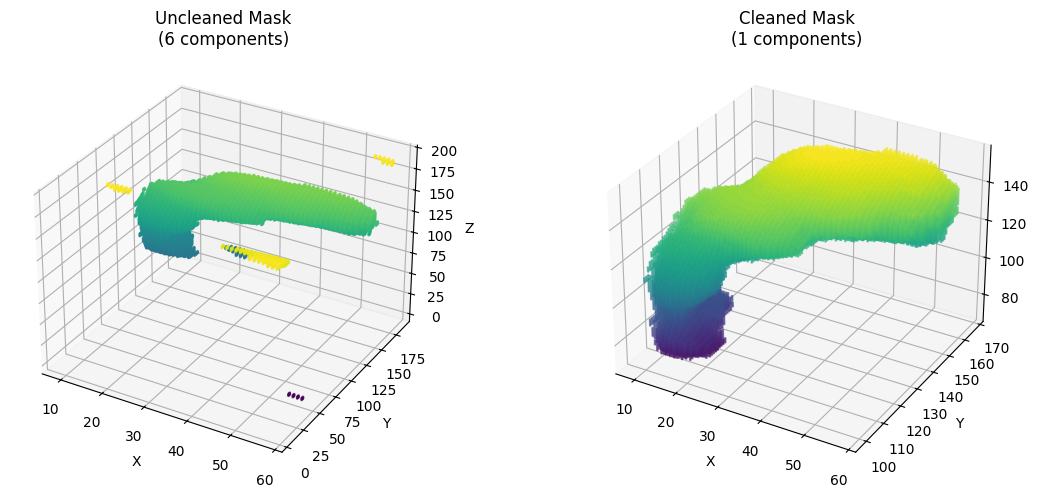


--- Component Analysis for Volume 4 ---

--- Volume 4 Comparison ---
Uncleaned: 10 components, 51587 voxels
Cleaned:   1 components, 49889 voxels
Removed:   1698 voxels
Reduction: 3.3%


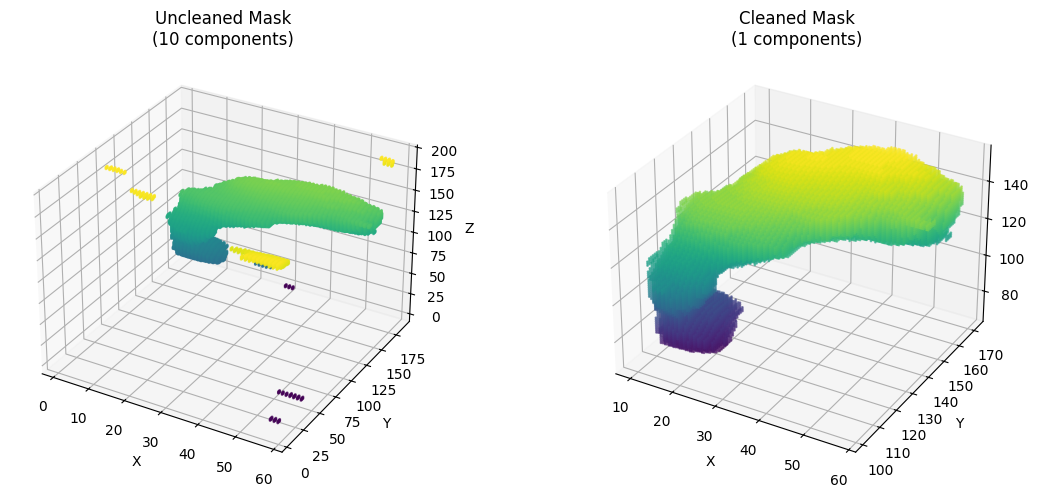


=== SUMMARY STATISTICS FOR ALL 5 VOLUMES ===

Overall Statistics:
  Total original components: 55
  Total original voxels: 220,431
  Total cleaned voxels: 209,886.0
  Overall reduction: 4.8%
  Average components per volume: 11.0
  Average reduction per volume: 3.9%


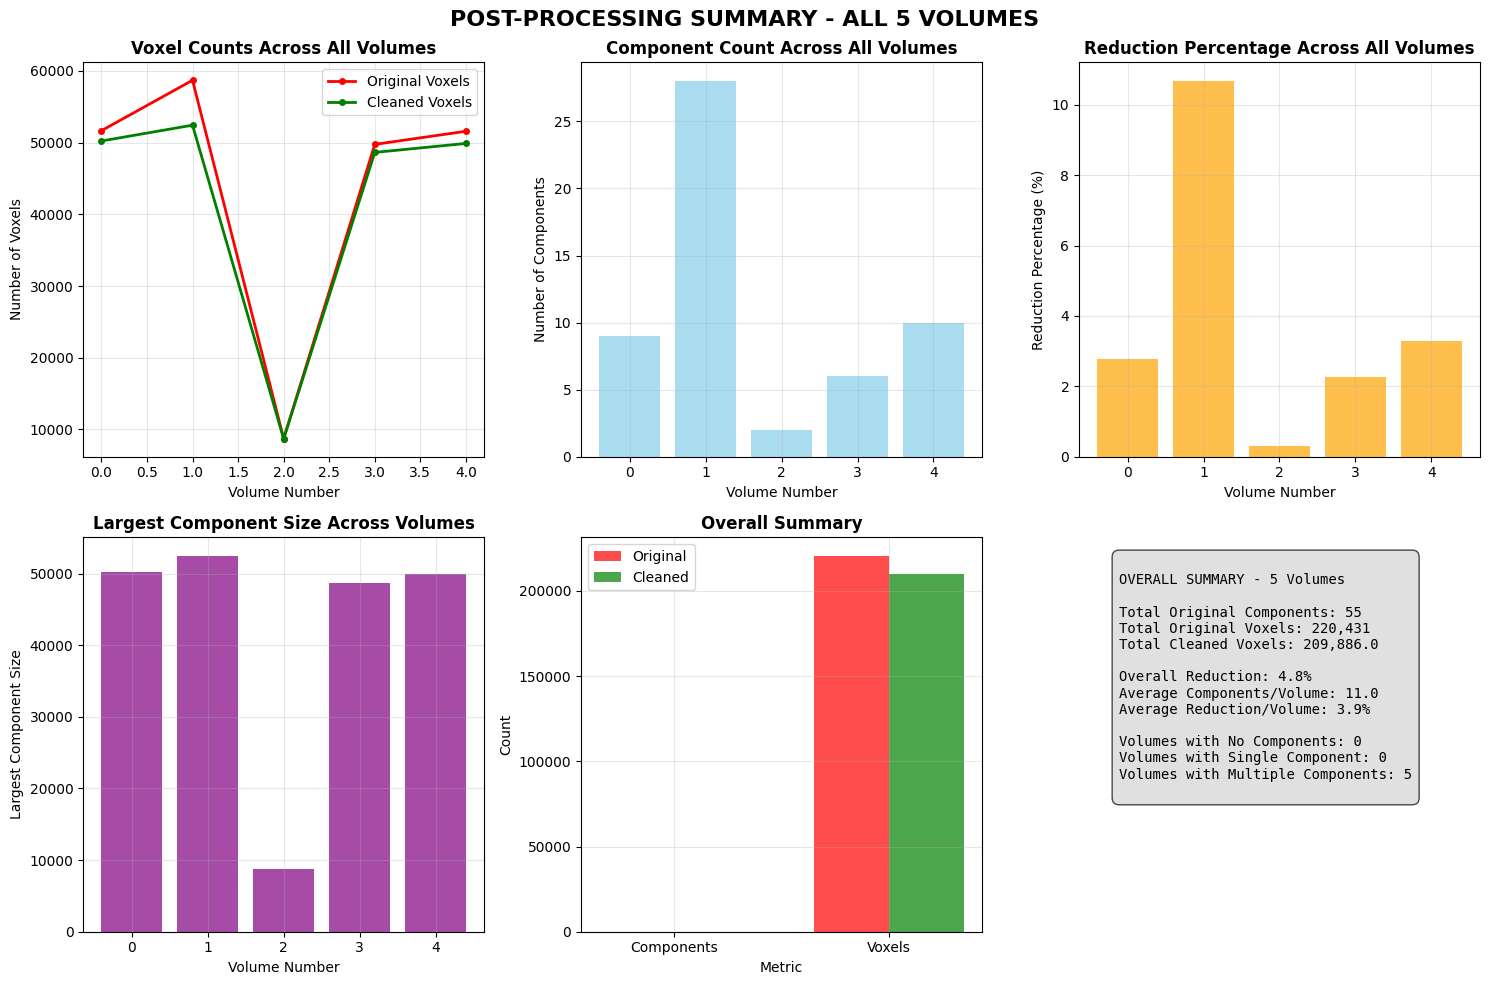


Do you want to save the cleaned mask? (y/n):  y
Enter filename for cleaned data (e.g., 'cleaned_largest_component_segmentation.nii'):  segmented_organ_stomach


✓ Cleaned 4D mask saved as 'segmented_organ_stomach'

=== POST-PROCESSING COMPLETED SUCCESSFULLY ===
✓ Processed and displayed ALL 5 volumes
✓ Largest component extraction applied to all volumes
✓ Comprehensive visualizations created for each volume
✓ Volume statistics calculated
✓ Cleaned data stored in variable 'cleaned_mask_4d'

Available variables for next steps:
  - cleaned_mask_4d: Cleaned binary 4D data (shape: (192, 192, 60, 5))
  - input_mask: Original segmented data (shape: (192, 192, 60, 5))
  - volume_stats: List of statistics for each volume

=== FINAL SUMMARY ===
Total volumes processed: 5
Overall voxel reduction: 4.8%
Average components per volume: 11.0


In [4]:
# =============================================================================
# POST-PROCESSING PIPELINE - LARGEST COMPONENT EXTRACTION
# =============================================================================

print("=== POST-PROCESSING PIPELINE - LARGEST COMPONENT EXTRACTION ===")

# Check if segmented data is available from Otsu thresholding
try:
    # Use the segmented data from Otsu thresholding
    input_mask = segmented_4d
    input_affine = input_affine
    print("✓ Using segmented data from previous cell")
    
except NameError:
    # If not available, ask user to load segmented file
    print("Segmented data not found in memory. Please load segmented file.")
    segmented_filename = input("Enter filename of segmented data (e.g., 'T1w_1_segmented.nii'): ").strip()
    if not segmented_filename:
        segmented_filename = 'T1w_1_segmented.nii'
    
    try:
        segmented_img = nib.load(segmented_filename)
        input_mask = segmented_img.get_fdata().astype(np.uint8)
        input_affine = segmented_img.affine
        print(f"✓ Loaded segmented data from '{segmented_filename}'")
    except:
        print("Error: Could not load segmented file. Please run Otsu thresholding first.")
        raise

print(f"\n=== INPUT DATA FOR POST-PROCESSING ===")
print(f"4D mask dimensions: {input_mask.shape}")
print(f"Number of 3D volumes: {input_mask.shape[3]}")

# Initialize cleaned mask
cleaned_mask_4d = np.zeros_like(input_mask, dtype=np.uint8)
volume_stats = []

print(f"\n=== PROCESSING {input_mask.shape[3]} VOLUMES ===")

# Process each volume independently
for vol_idx in range(input_mask.shape[3]):
    print(f"Cleaning volume {vol_idx+1}/{input_mask.shape[3]}...")
    
    mask = input_mask[..., vol_idx]

    # Connected component labeling
    labeled, num_features = ndimage.label(mask)

    if num_features == 0:
        print("  No components found → leaving empty.")
        volume_stats.append({
            'volume': vol_idx,
            'original_components': 0,
            'original_voxels': 0,
            'cleaned_voxels': 0,
            'largest_component_size': 0,
            'reduction_percent': 0
        })
        continue

    # Compute sizes of each component
    sizes = ndimage.sum(mask, labeled, range(1, num_features + 1))

    # Largest connected component
    largest_label = np.argmax(sizes) + 1
    largest_component = (labeled == largest_label)
    largest_size = sizes.max()

    cleaned_mask_4d[..., vol_idx] = largest_component.astype(np.uint8)

    # Calculate statistics
    original_voxels = np.sum(mask)
    cleaned_voxels = largest_size
    reduction_percent = ((original_voxels - cleaned_voxels) / original_voxels * 100) if original_voxels > 0 else 0
    
    volume_stats.append({
        'volume': vol_idx,
        'original_components': num_features,
        'original_voxels': original_voxels,
        'cleaned_voxels': cleaned_voxels,
        'largest_component_size': largest_size,
        'reduction_percent': reduction_percent
    })

    print(f"  Original: {num_features} components, {original_voxels} voxels")
    print(f"  Cleaned:  1 component, {cleaned_voxels} voxels")
    print(f"  Reduction: {reduction_percent:.1f}%")

# =============================================================================
# DISPLAY ALL VOLUMES - SLICE VIEWS
# =============================================================================

print(f"\n=== DISPLAYING ALL {input_mask.shape[3]} VOLUMES ===")

def display_slices(uncleaned, cleaned, volume_idx=0, num_slices=9):
    """Display slices from uncleaned and cleaned masks side by side"""
    
    # Get middle slices to display
    z_size = uncleaned.shape[2]
    slice_indices = np.linspace(0, z_size-1, num_slices, dtype=int)
    
    fig, axes = plt.subplots(2, num_slices, figsize=(15, 4))
    fig.suptitle(f'Volume {volume_idx}: Uncleaned (top) vs Cleaned (bottom) Masks', fontsize=16)
    
    for i, slice_idx in enumerate(slice_indices):
        # Display uncleaned mask
        axes[0, i].imshow(uncleaned[:, :, slice_idx, volume_idx], cmap='gray')
        axes[0, i].set_title(f'Slice {slice_idx}')
        axes[0, i].axis('off')
        
        # Display cleaned mask
        axes[1, i].imshow(cleaned[:, :, slice_idx, volume_idx], cmap='gray')
        axes[1, i].set_title(f'Slice {slice_idx}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display slice views for ALL volumes
for vol_idx in range(input_mask.shape[3]):
    print(f"\n--- Displaying Volume {vol_idx} ---")
    display_slices(input_mask, cleaned_mask_4d, volume_idx=vol_idx)

# =============================================================================
# DISPLAY ALL VOLUMES - COMPONENT COMPARISON
# =============================================================================

def display_component_comparison(uncleaned, cleaned, volume_idx=0):
    """Display statistics and comparison between uncleaned and cleaned masks"""
    
    uncleaned_vol = uncleaned[..., volume_idx]
    cleaned_vol = cleaned[..., volume_idx]
    
    # Calculate statistics
    uncleaned_components, uncleaned_num = ndimage.label(uncleaned_vol)
    cleaned_components, cleaned_num = ndimage.label(cleaned_vol)
    
    uncleaned_voxels = np.sum(uncleaned_vol)
    cleaned_voxels = np.sum(cleaned_vol)
    
    print(f"\n--- Volume {volume_idx} Comparison ---")
    print(f"Uncleaned: {uncleaned_num} components, {uncleaned_voxels} voxels")
    print(f"Cleaned:   {cleaned_num} components, {cleaned_voxels} voxels")
    print(f"Removed:   {uncleaned_voxels - cleaned_voxels} voxels")
    print(f"Reduction: {((uncleaned_voxels - cleaned_voxels) / uncleaned_voxels * 100):.1f}%")
    
    # Display 3D visualization
    fig = plt.figure(figsize=(12, 5))
    
    # Uncleaned mask
    ax1 = fig.add_subplot(121, projection='3d')
    z, y, x = uncleaned_vol.nonzero()
    if len(x) > 0:  # Only plot if there are points
        ax1.scatter(x, y, z, c=z, cmap='viridis', s=1, alpha=0.6)
    ax1.set_title(f'Uncleaned Mask\n({uncleaned_num} components)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Cleaned mask
    ax2 = fig.add_subplot(122, projection='3d')
    z, y, x = cleaned_vol.nonzero()
    if len(x) > 0:  # Only plot if there are points
        ax2.scatter(x, y, z, c=z, cmap='viridis', s=1, alpha=0.6)
    ax2.set_title(f'Cleaned Mask\n({cleaned_num} components)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    plt.tight_layout()
    plt.show()

# Display component comparisons for ALL volumes
for vol_idx in range(input_mask.shape[3]):
    print(f"\n--- Component Analysis for Volume {vol_idx} ---")
    display_component_comparison(input_mask, cleaned_mask_4d, volume_idx=vol_idx)

# =============================================================================
# SUMMARY STATISTICS FOR ALL VOLUMES
# =============================================================================

print(f"\n=== SUMMARY STATISTICS FOR ALL {input_mask.shape[3]} VOLUMES ===")

if volume_stats:
    total_original_components = sum(stat['original_components'] for stat in volume_stats)
    total_original_voxels = sum(stat['original_voxels'] for stat in volume_stats)
    total_cleaned_voxels = sum(stat['cleaned_voxels'] for stat in volume_stats)
    overall_reduction = ((total_original_voxels - total_cleaned_voxels) / total_original_voxels * 100) if total_original_voxels > 0 else 0
    
    print(f"\nOverall Statistics:")
    print(f"  Total original components: {total_original_components:,}")
    print(f"  Total original voxels: {total_original_voxels:,}")
    print(f"  Total cleaned voxels: {total_cleaned_voxels:,}")
    print(f"  Overall reduction: {overall_reduction:.1f}%")
    print(f"  Average components per volume: {total_original_components/len(volume_stats):.1f}")
    print(f"  Average reduction per volume: {np.mean([stat['reduction_percent'] for stat in volume_stats]):.1f}%")
    
    # Create summary visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Voxel counts across all volumes
    plt.subplot(2, 3, 1)
    volumes = range(len(volume_stats))
    original_voxels = [stat['original_voxels'] for stat in volume_stats]
    cleaned_voxels = [stat['cleaned_voxels'] for stat in volume_stats]
    
    plt.plot(volumes, original_voxels, 'ro-', linewidth=2, markersize=4, label='Original Voxels')
    plt.plot(volumes, cleaned_voxels, 'go-', linewidth=2, markersize=4, label='Cleaned Voxels')
    plt.xlabel('Volume Number')
    plt.ylabel('Number of Voxels')
    plt.title('Voxel Counts Across All Volumes', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Component count across volumes
    plt.subplot(2, 3, 2)
    component_counts = [stat['original_components'] for stat in volume_stats]
    plt.bar(volumes, component_counts, color='skyblue', alpha=0.7)
    plt.xlabel('Volume Number')
    plt.ylabel('Number of Components')
    plt.title('Component Count Across All Volumes', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Reduction percentage
    plt.subplot(2, 3, 3)
    reduction_percentages = [stat['reduction_percent'] for stat in volume_stats]
    plt.bar(volumes, reduction_percentages, color='orange', alpha=0.7)
    plt.xlabel('Volume Number')
    plt.ylabel('Reduction Percentage (%)')
    plt.title('Reduction Percentage Across All Volumes', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Largest component size
    plt.subplot(2, 3, 4)
    largest_sizes = [stat['largest_component_size'] for stat in volume_stats]
    plt.bar(volumes, largest_sizes, color='purple', alpha=0.7)
    plt.xlabel('Volume Number')
    plt.ylabel('Largest Component Size')
    plt.title('Largest Component Size Across Volumes', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Overall summary
    plt.subplot(2, 3, 5)
    categories = ['Components', 'Voxels']
    original_vals = [total_original_components, total_original_voxels]
    cleaned_vals = [len(volume_stats), total_cleaned_voxels]  # Components after cleaning is always 1 per volume (or 0)
    
    x = np.arange(len(categories))
    width = 0.35
    
    plt.bar(x - width/2, original_vals, width, label='Original', color='red', alpha=0.7)
    plt.bar(x + width/2, cleaned_vals, width, label='Cleaned', color='green', alpha=0.7)
    
    plt.xlabel('Metric')
    plt.ylabel('Count')
    plt.title('Overall Summary', fontweight='bold')
    plt.xticks(x, categories)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Volume-wise statistics table
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # Create a text summary
    summary_text = f"""
OVERALL SUMMARY - {len(volume_stats)} Volumes

Total Original Components: {total_original_components:,}
Total Original Voxels: {total_original_voxels:,}
Total Cleaned Voxels: {total_cleaned_voxels:,}

Overall Reduction: {overall_reduction:.1f}%
Average Components/Volume: {total_original_components/len(volume_stats):.1f}
Average Reduction/Volume: {np.mean([stat['reduction_percent'] for stat in volume_stats]):.1f}%

Volumes with No Components: {sum(1 for stat in volume_stats if stat['original_components'] == 0)}
Volumes with Single Component: {sum(1 for stat in volume_stats if stat['original_components'] == 1)}
Volumes with Multiple Components: {sum(1 for stat in volume_stats if stat['original_components'] > 1)}
"""
    
    plt.text(0.1, 0.95, summary_text, transform=plt.gca().transAxes, fontfamily='monospace', 
             fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.7))
    
    plt.suptitle(f'POST-PROCESSING SUMMARY - ALL {len(volume_stats)} VOLUMES', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
else:
    print("No volumes were processed successfully.")

# =============================================================================
# SAVE OPTIONS
# =============================================================================

# Option to save cleaned mask
save_cleaned = input("\nDo you want to save the cleaned mask? (y/n): ").lower().strip()
if save_cleaned == 'y':
    cleaned_filename = input("Enter filename for cleaned data (e.g., 'cleaned_largest_component_segmentation.nii'): ").strip()
    if not cleaned_filename:
        cleaned_filename = 'cleaned_largest_component_segmentation.nii'
    
    cleaned_nifti = nib.Nifti1Image(cleaned_mask_4d.astype(np.uint8), input_affine)
    nib.save(cleaned_nifti, cleaned_filename)
    print(f"✓ Cleaned 4D mask saved as '{cleaned_filename}'")

print("\n=== POST-PROCESSING COMPLETED SUCCESSFULLY ===")
print(f"✓ Processed and displayed ALL {input_mask.shape[3]} volumes")
print("✓ Largest component extraction applied to all volumes")
print("✓ Comprehensive visualizations created for each volume")
print("✓ Volume statistics calculated")
print("✓ Cleaned data stored in variable 'cleaned_mask_4d'")

print(f"\nAvailable variables for next steps:")
print(f"  - cleaned_mask_4d: Cleaned binary 4D data (shape: {cleaned_mask_4d.shape})")
print(f"  - input_mask: Original segmented data (shape: {input_mask.shape})")
print(f"  - volume_stats: List of statistics for each volume")

print(f"\n=== FINAL SUMMARY ===")
print(f"Total volumes processed: {len(volume_stats)}")
if volume_stats:
    print(f"Overall voxel reduction: {overall_reduction:.1f}%")
    print(f"Average components per volume: {total_original_components/len(volume_stats):.1f}")